# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [495]:
!pip install folium

In [496]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [497]:
!pip install seaborn

In [498]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [499]:
df = pd.read_csv('train.csv')

In [500]:
df

id  vendor_id  ... store_and_fwd_flag trip_duration
0        id2875421          2  ...                  N           455
1        id2377394          1  ...                  N           663
2        id3858529          2  ...                  N          2124
3        id3504673          2  ...                  N           429
4        id2181028          2  ...                  N           435
...            ...        ...  ...                ...           ...
1458639  id2376096          2  ...                  N           778
1458640  id1049543          1  ...                  N           655
1458641  id2304944          2  ...                  N           764
1458642  id2714485          1  ...                  N           373
1458643  id1209952          1  ...                  N           198

[1458644 rows x 11 columns]

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [501]:
df.drop(['dropoff_datetime'], axis=1, inplace=True)

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

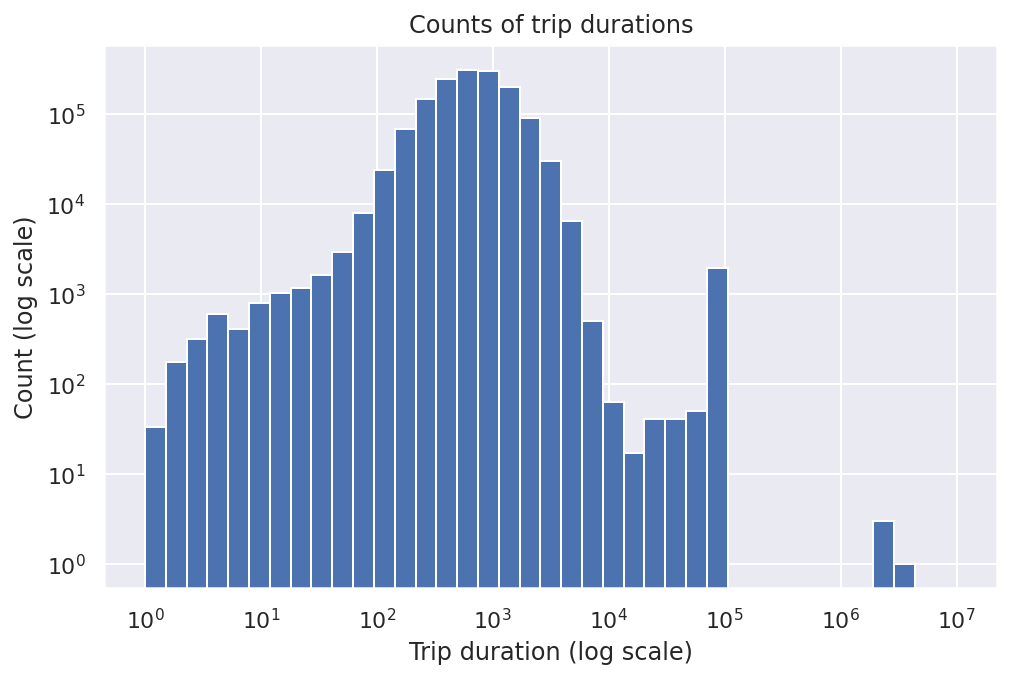

In [502]:
logbins = np.logspace(np.log10(1),np.log10(1e7), 40)
plt.hist(df.trip_duration, bins=logbins)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Count (log scale)')
plt.xlabel('Trip duration (log scale)')
plt.title('Counts of trip durations')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Есть выбросы, если их не считать то чем-то напоминает нормальное.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Из-за выбросов, предсказания на выбрасах не важны, потому что скорее всего поездка длилось иной время или её не было

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: 

$a(x_i) = \exp(\hat{a}(x_i)) - 1$

$\hat{a}(x_i) = \log(a(x_i) + 1)$

$MSE(X,\hat{y},\hat{a}) = MSE(X, \log{(y_i + 1)}, \log(a(x_i) + 1)) = \frac{1}{\ell}\sum_{i=1}^{\ell}(\log{(y_i + 1)} - \log{(a(x_i) + 1)})^2 = (RMSLE(X,y,a))^2$

А это понятно почему эквивалентно - оба числа были положительны (RMSLE не в квадрате в частности). И уменьшение RMSLE эквивалентно уменьшению MSE для данных моделей

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [503]:
df['log_trip_duration'] = (np.log1p(df.trip_duration))
df.drop(['trip_duration'], axis=1, inplace=True)

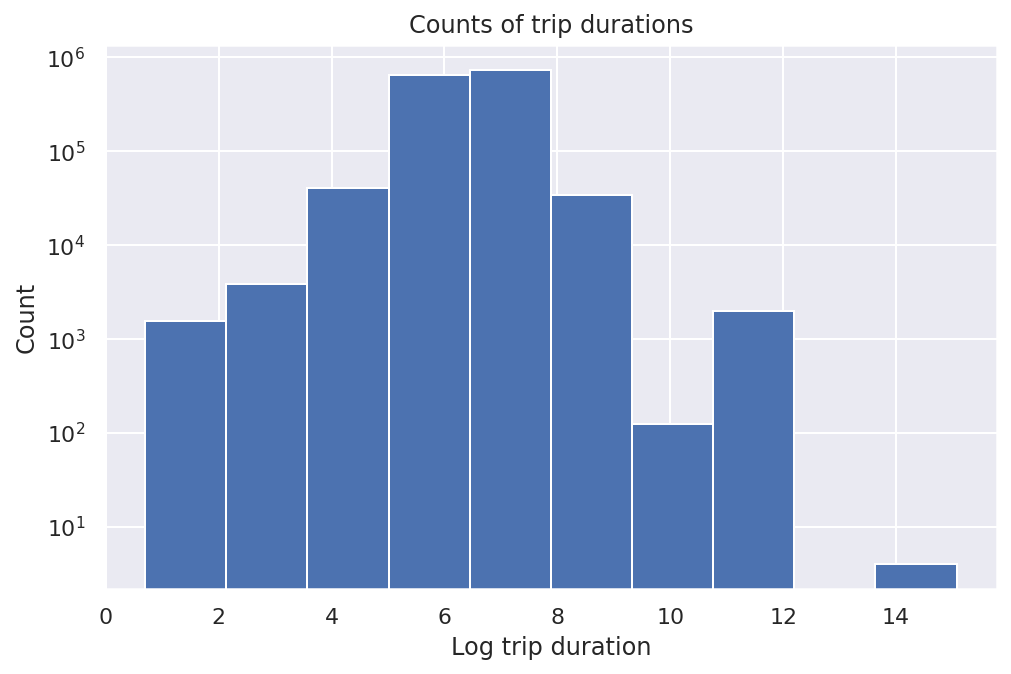

In [504]:
plt.hist(df.log_trip_duration)
plt.yscale('log')  # не логарифмируем ось х
plt.ylabel('Count')
plt.xlabel('Log trip duration')
plt.title('Counts of trip durations')
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [505]:
print('RMSE = ', df.log_trip_duration.std(), '\nMSE = ', df.log_trip_duration.std() ** 2)

RMSE =  0.7957595093149854 
MSE =  0.6332331966652264


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [506]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


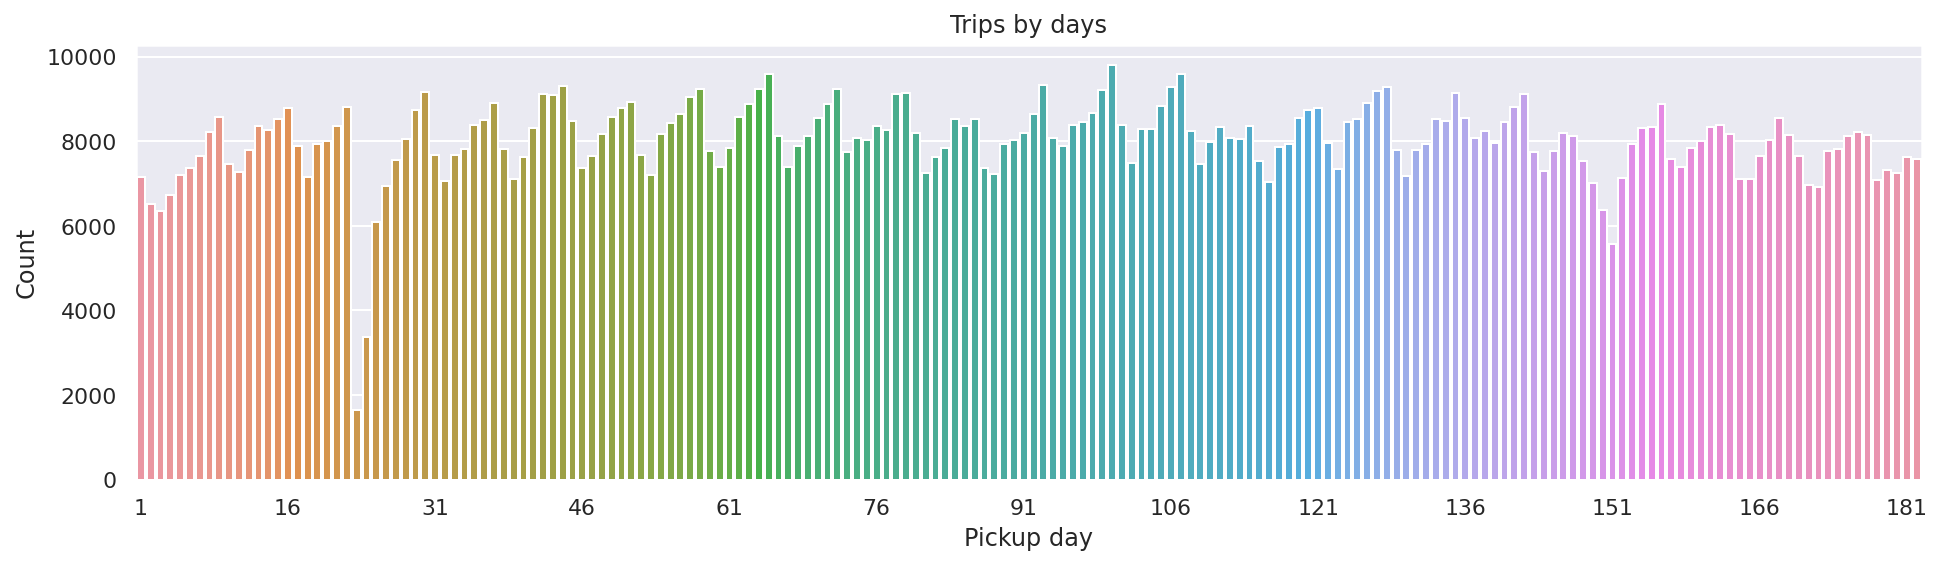

In [507]:
ax = sns.countplot(df.pickup_datetime.dt.dayofyear)
ax.set(title='Trips by days', xlabel='Pickup day', ylabel='Count')
ax.figure.set_size_inches(16, 4)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 15 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [508]:
gruped_df = df.groupby(pd.Grouper(key='pickup_datetime',freq='D')).count()
gruped_df[gruped_df['id'] < 6500].id

pickup_datetime
2016-01-03    6353
2016-01-23    1648
2016-01-24    3383
2016-01-25    6084
2016-05-29    6372
2016-05-30    5570
Name: id, dtype: int64

In [509]:
del(gruped_df)

2016-01-23(24): [Снегопад](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard)

2016-05-30(29): Просадок не большой, однако может быть связан с [проблемами в аэропорту](https://edition.cnn.com/2016/05/30/us/jfk-delays-memorial-day-weekend/index.html)

2016-01-03: не наш случай, скорее всего просто выброс

Про графики сказали в чате, что можно не relplot сделать, поэтому вот

In [510]:
df['hour'] = df.pickup_datetime.dt.hour
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.dayofweek
df['day_of_year'] = df.pickup_datetime.dt.dayofyear
df_weekday = df.groupby(['weekday'], as_index=False).count()
df_hour = df.groupby(['hour'], as_index=False).count()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


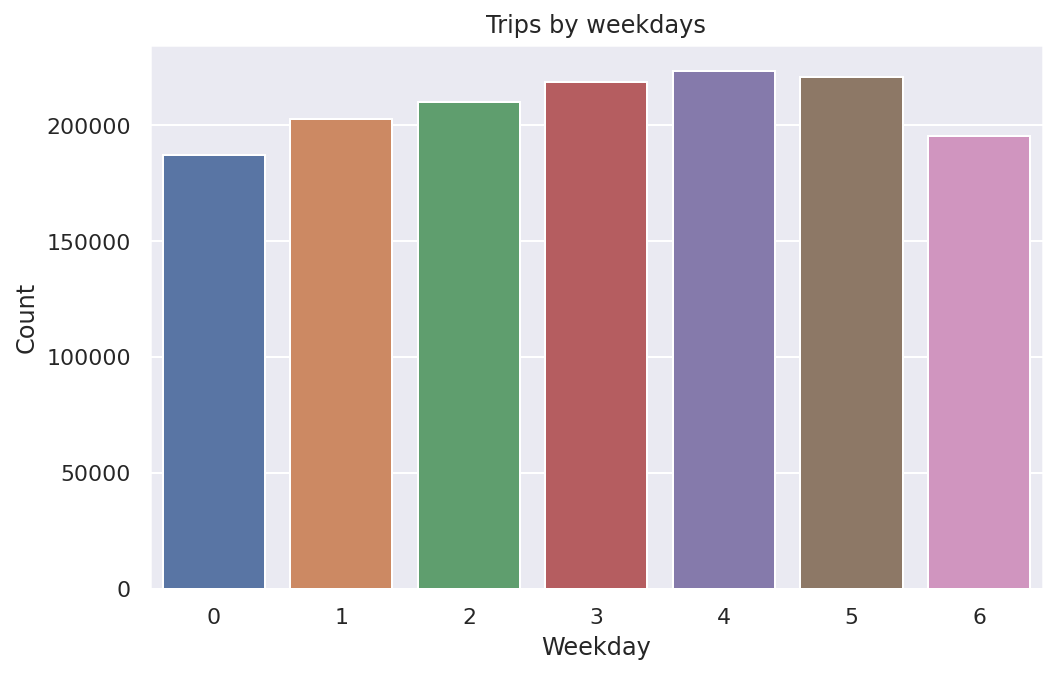

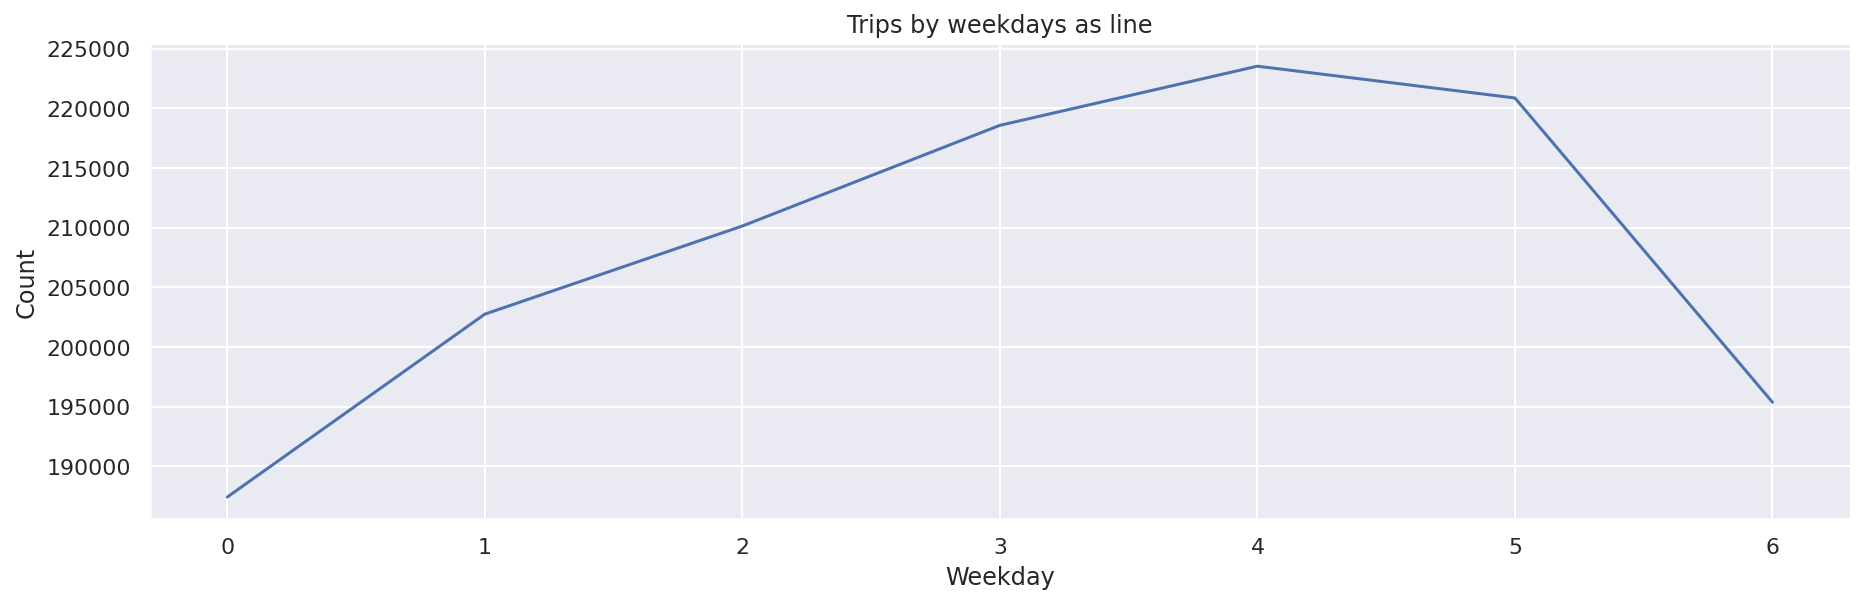

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


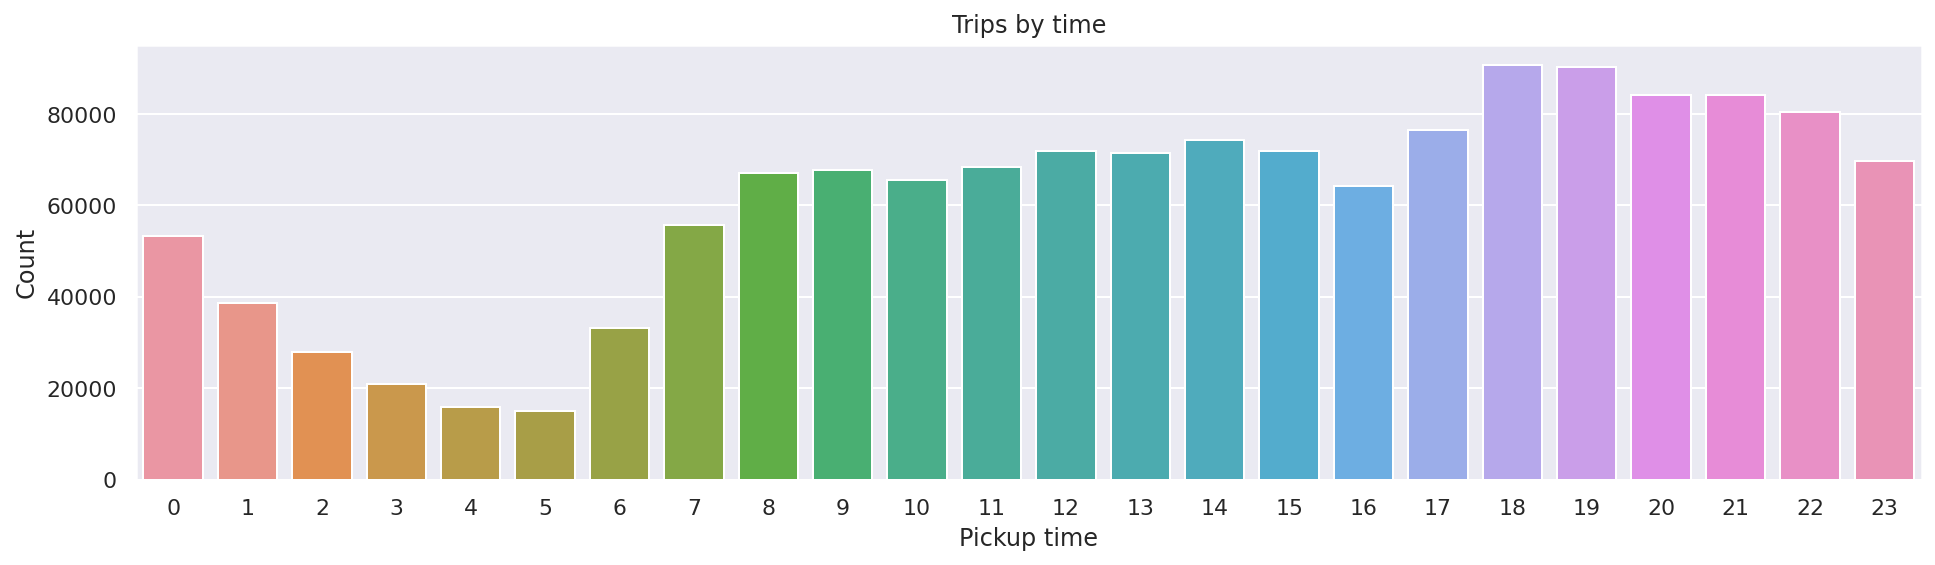

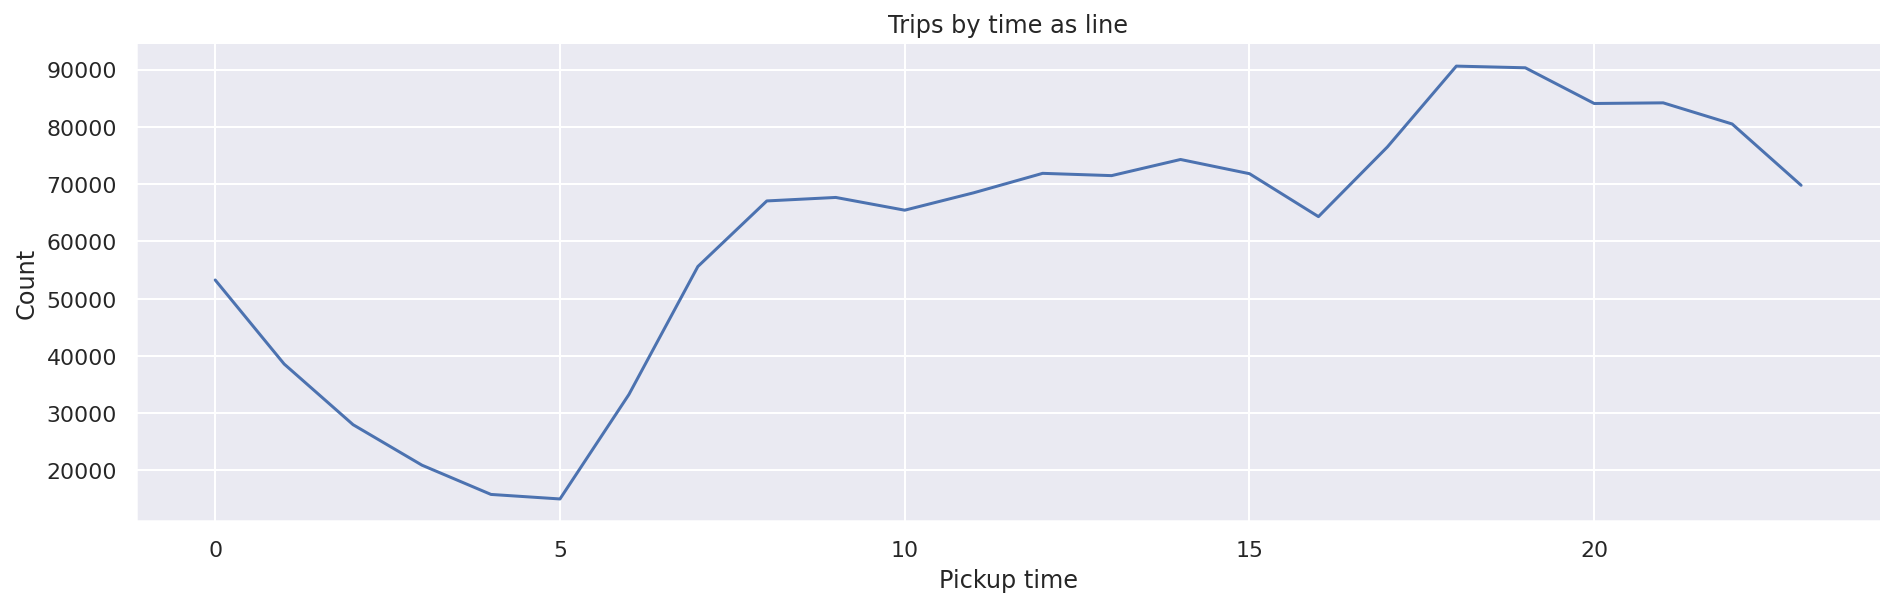

In [511]:
# Day of week
ax = sns.countplot(df.pickup_datetime.dt.dayofweek)
ax.set(title='Trips by weekdays', xlabel='Weekday', ylabel='Count')
plt.show()

ax = sns.relplot(x='weekday', y='id', data=df_weekday, kind='line')
ax.set(title='Trips by weekdays as line', xlabel='Weekday', ylabel='Count')
ax.figure.set_size_inches(16, 4)
plt.show()

# Time
ax = sns.countplot(df.pickup_datetime.dt.hour)
ax.set(title='Trips by time', xlabel='Pickup time', ylabel='Count')
ax.figure.set_size_inches(16, 4)
sns.lineplot(ax=ax)

ax = sns.relplot(x='hour', y='id', data=df_hour, kind='line')
ax.set(title='Trips by time as line', xlabel='Pickup time', ylabel='Count')
ax.figure.set_size_inches(16, 4)
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

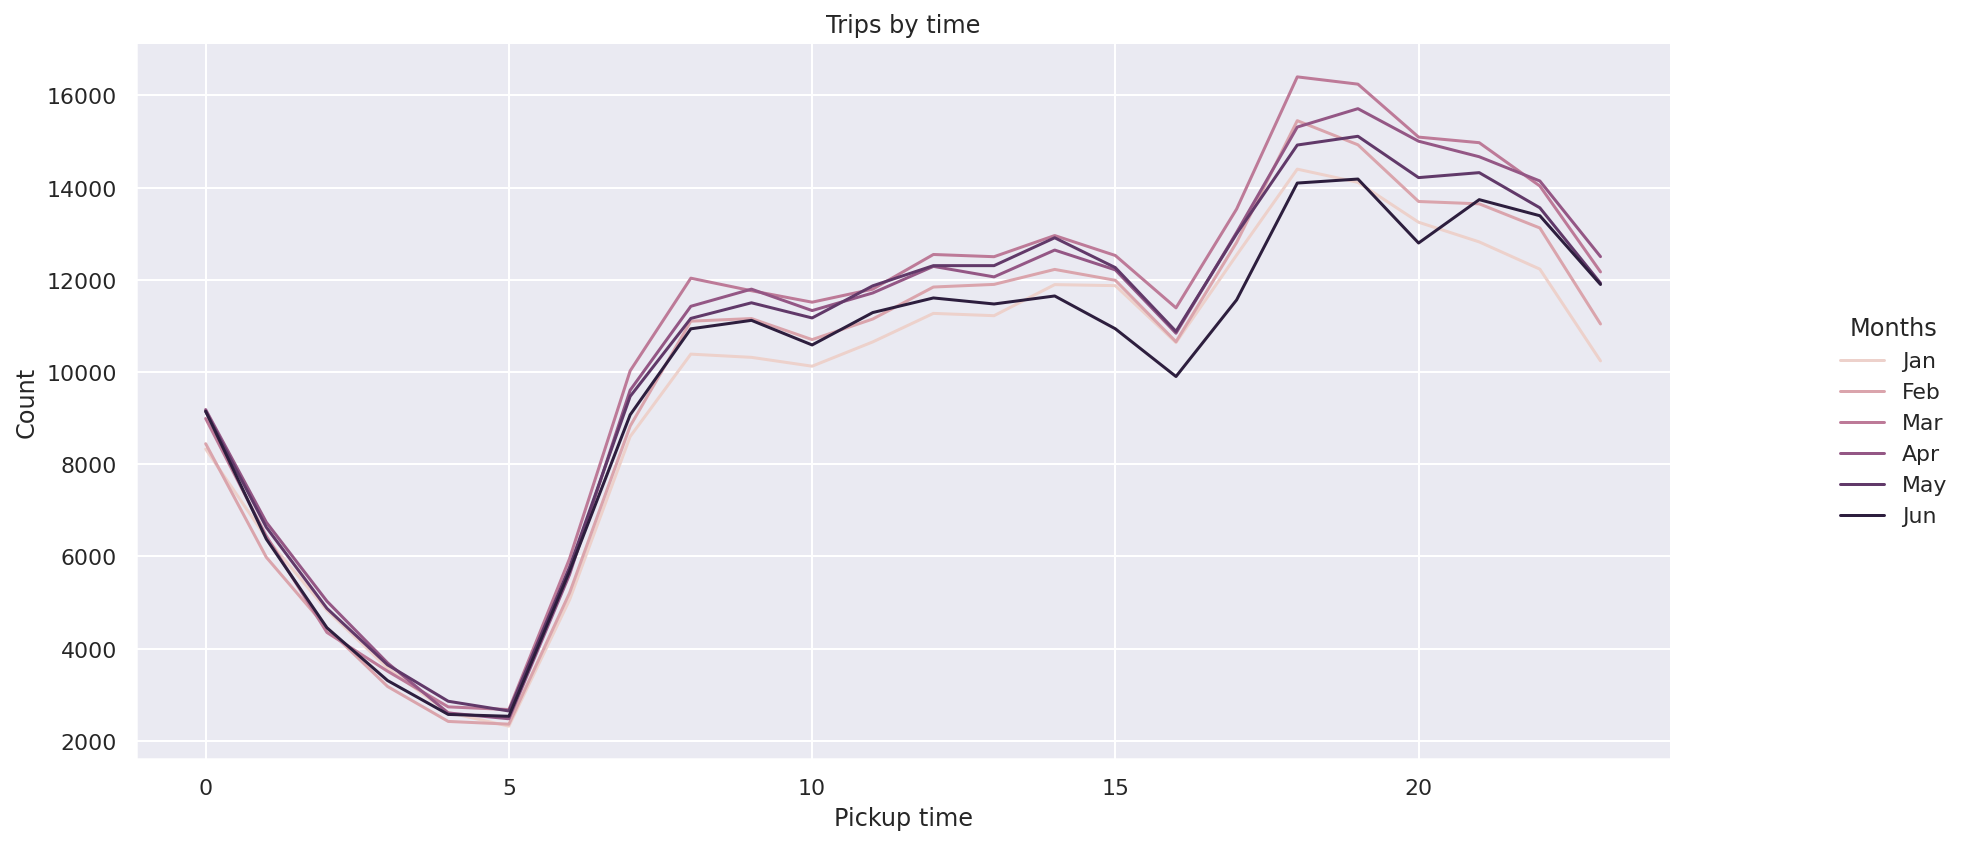

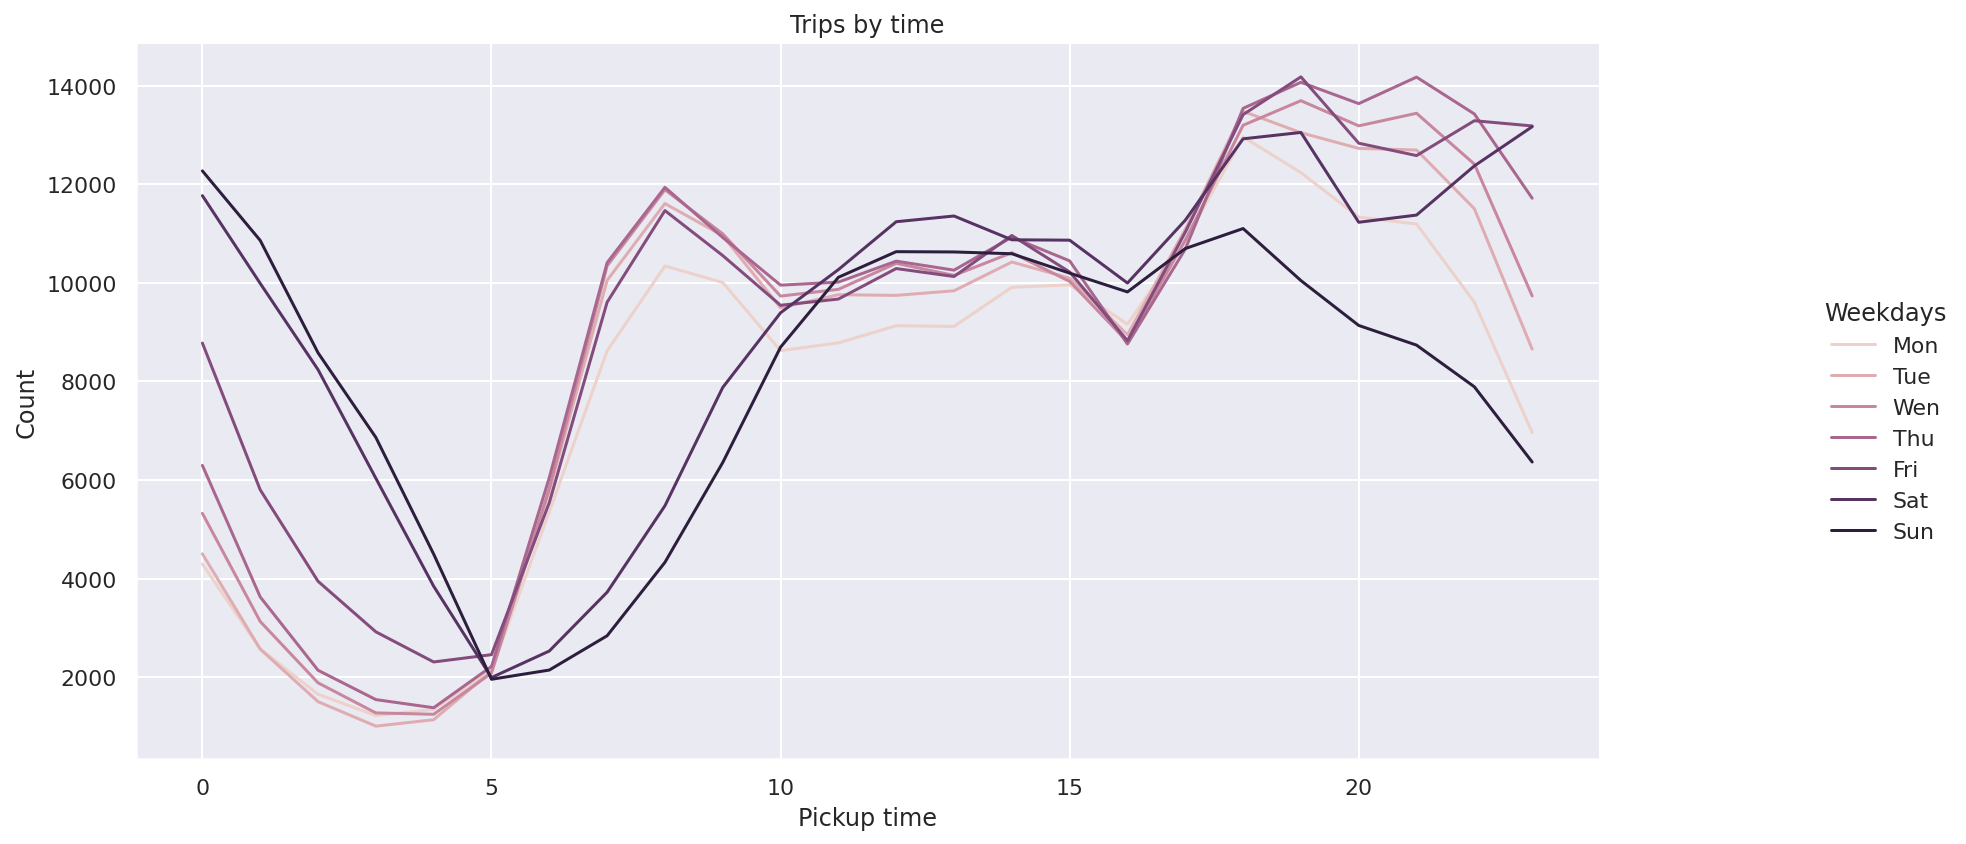

In [512]:
# Monthly
data_viz = df.groupby(['hour', 'month'], as_index=False).count()
ax = sns.relplot(hue='month', x='hour', y='id', data=data_viz, kind='line', legend='full')
ax.set(title='Trips by time', xlabel='Pickup time', ylabel='Count')
ax.figure.set_size_inches(16, 6)
leg = ax._legend
leg.set_title("Months")
for i, month in enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']):
    leg.texts[i].set_text(month)

plt.show()

data_viz = df.groupby(['hour', 'weekday'], as_index=False).count()
# Weekday
ax = sns.relplot(hue='weekday', x='hour', y='id', data=data_viz, kind='line', legend='full')
ax.set(title='Trips by time', xlabel='Pickup time', ylabel='Count')
ax.figure.set_size_inches(16, 6)
leg = ax._legend
leg.set_title("Weekdays")
for i, month in enumerate(['Mon', 'Tue', 'Wen', 'Thu', 'Fri', 'Sat', 'Sun']):
    leg.texts[i].set_text(month)

plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Количество поездкок зависит от времени вызова, от дня недели, а вот от месяца послабее.

Выделяются ли какие-нибудь дни недели? Да, в пятницу и субботу самое большое количество поездок, тогда как в понедельник и воскресенье самое маленькое

Месяца? Не очень сильно

Время суток? Да, логично, что люди спят ночью

С чем это связано? С разными причинами, например, для дня недели люди могут отдыхать без машины или быть не в состоянии сесть за руль (например, выпившими), обычно это происходит в пятницу-субботу


**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [513]:
delimeter = int((df.shape[0] * 7) / 10)
train = df.loc[:delimeter].copy()
test = df.loc[delimeter:].copy()

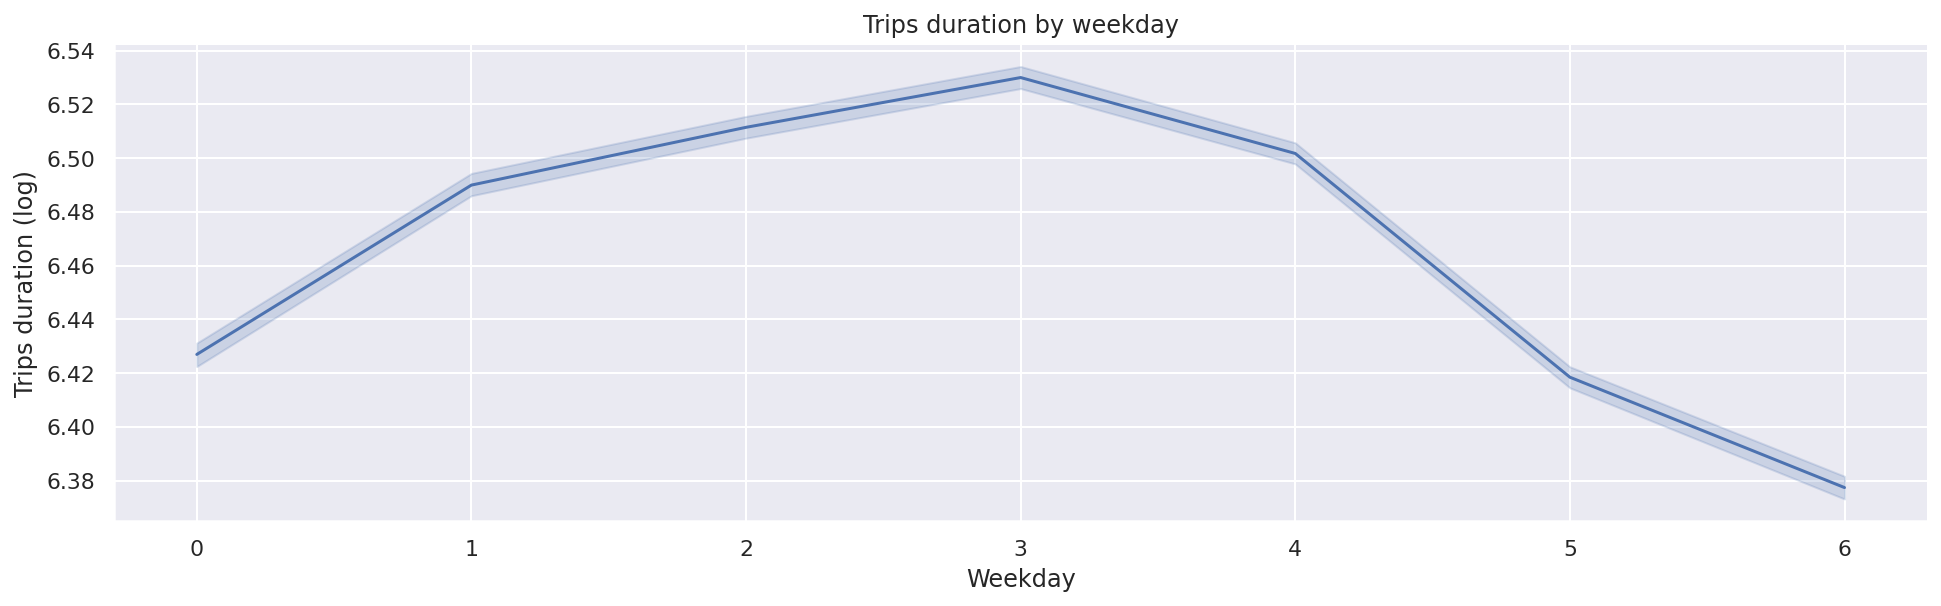

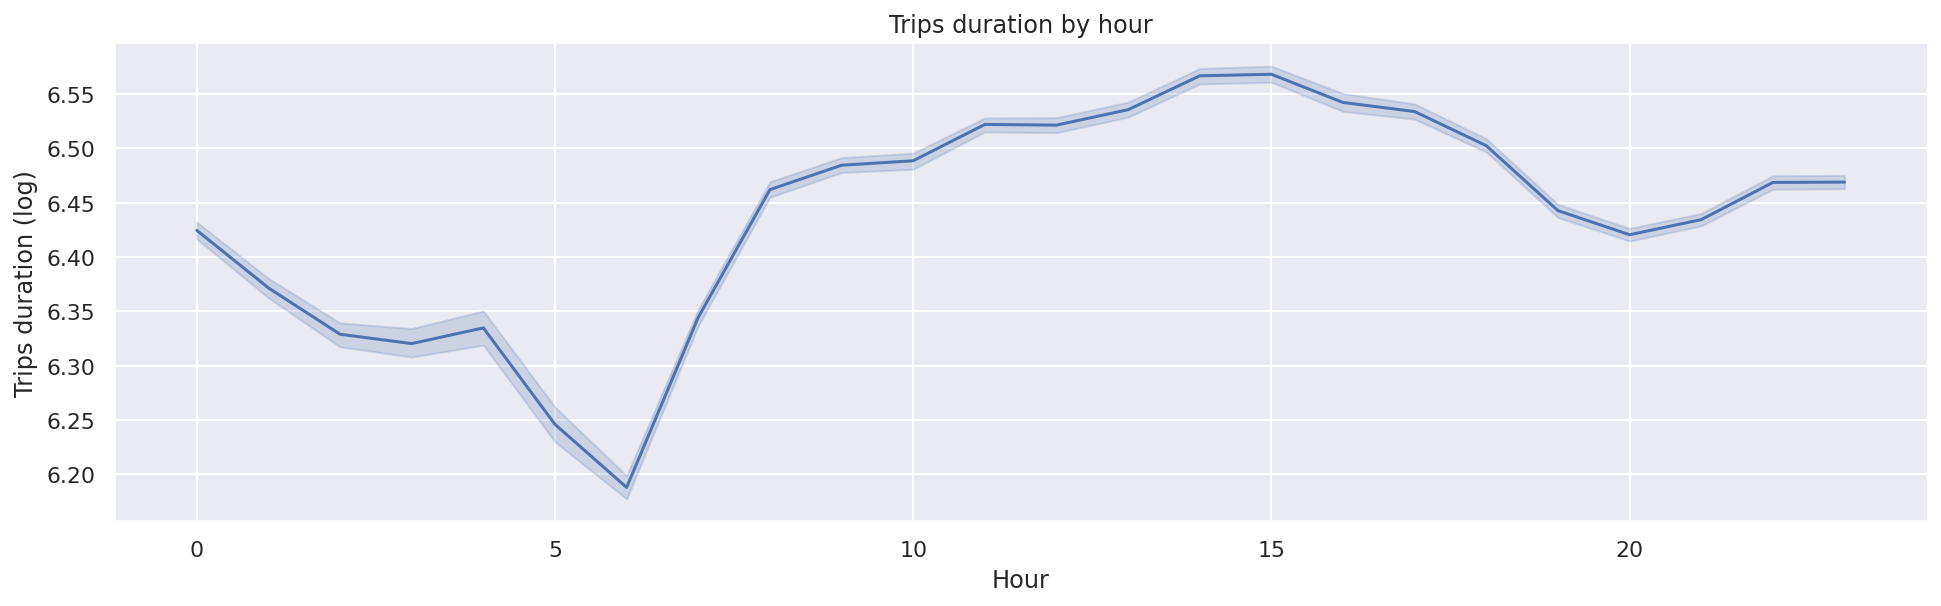

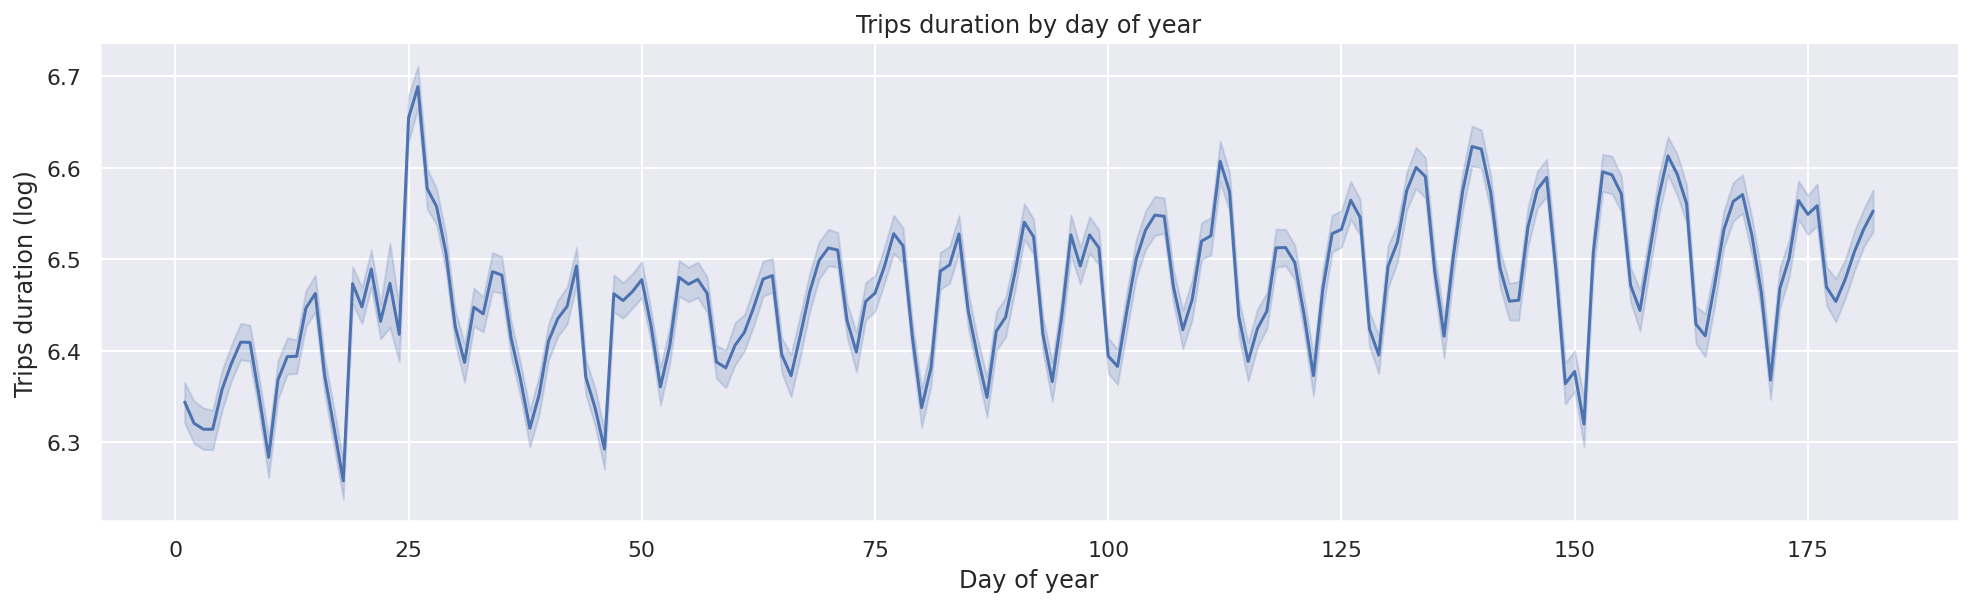

In [514]:
# Weekday
ax = sns.relplot(y='log_trip_duration', x='weekday', data=train, kind='line')
ax.set(title='Trips duration by weekday', xlabel='Weekday', ylabel='Trips duration (log)')
ax.figure.set_size_inches(16, 4)

# Time
ax = sns.relplot(y='log_trip_duration', x='hour', data=train, kind='line')
ax.set(title='Trips duration by hour', xlabel='Hour', ylabel='Trips duration (log)')
ax.figure.set_size_inches(16, 4)

# Day in year
ax = sns.relplot(y='log_trip_duration', x='day_of_year', data=train, kind='line')
ax.set(title='Trips duration by day of year', xlabel='Day of year', ylabel='Trips duration (log)')
ax.figure.set_size_inches(16, 4)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? В целом, напоминает.

Почему? Разные причины, например, если вам идти недалеко, то вы более вероятно выберете пройтись днём, а не ночью.

Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Trips duration или очень большой, или маленький.

Почему так происходит? Скорее всего заказы так и не завершились.

Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году? Цикличный разве что, возможно небольшой рост.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели - 'weekday'
2. Месяц - 'month'
3. Час - 'hour'
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам) - 
5. Номер дня в году - 'day_of_year'

In [515]:
train['is_anomaly_v1'] = 0
test['is_anomaly_v1'] = 0
train['is_anomaly_v2'] = 0
test['is_anomaly_v2'] = 0

In [516]:
train.loc[(train['day_of_year'] == 23) | (train['day_of_year'] == 24), 'is_anomaly_v1'] = 1
test.loc[(test['day_of_year'] == 23) | (test['day_of_year'] == 24), 'is_anomaly_v1'] = 1
train.loc[(train['day_of_year'] == 151) | (train['day_of_year'] == 150), 'is_anomaly_v2'] = 1
test.loc[(test['day_of_year'] == 151) | (test['day_of_year'] == 150), 'is_anomaly_v2'] = 1

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные? weekday, hour

A какие - как численные? month, day_of_year, is_anomaly_v1, is_anomaly_v2

Почему? weekday и hour совсем нелинейны. А слоёв нелинейности нет

month, day_of_year, с нелинейными weekday и hour, должны давать около линейные или нулевые результаты. is_anomaly_v1, is_anomaly_v2 категориальные но принимают 0 или 1 поэтому пойдут в числовые, чтобы не увеличивать количество признаков

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [517]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [518]:
def BuildPredict(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_train_pred = model.predict(X_train)

  print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
  print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
  return mean_squared_error(y_test, y_pred, squared=False)

In [519]:
ohe = OneHotEncoder(sparse=False)

In [520]:
X_numeric = train[['day_of_year', 'month', 'is_anomaly_v1', 'is_anomaly_v2']]
scaler = StandardScaler().fit(X_numeric)
X_numeric = scaler.transform(X_numeric)
X_train = np.append(ohe.fit_transform(train[['weekday', 'hour']]), X_numeric, axis=1)
y_train = train['log_trip_duration']

In [521]:
X_numeric = test[['day_of_year', 'month', 'is_anomaly_v1', 'is_anomaly_v2']]
X_numeric = scaler.transform(X_numeric)
scaler = StandardScaler().fit(X_numeric)
X_test = np.append(ohe.fit_transform(test[['weekday', 'hour']]), X_numeric, axis=1)
y_test = test['log_trip_duration']

In [522]:
model = Ridge()
BuildPredict(model, X_train, y_train, X_test, y_test)

Test RMSE = 0.7889
Train RMSE = 0.7889


0.7888899065332454

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [523]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [524]:
show_circles_on_map(df.sample(2000), "pickup_latitude", "pickup_longitude", "blue")

In [525]:
show_circles_on_map(df.sample(2000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте? Аэропорт John F.Kennedy, 2-ю я бы назвал аэропорт Nework Liberty

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [526]:
train.head()

id  vendor_id  ... is_anomaly_v1  is_anomaly_v2
0  id2875421          2  ...             0              0
1  id2377394          1  ...             0              0
2  id3858529          2  ...             0              0
3  id3504673          2  ...             0              0
4  id2181028          2  ...             0              0

[5 rows x 16 columns]

In [527]:
from sklearn.metrics.pairwise import haversine_distances

In [528]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [529]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values,
                                           train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values,
                                           test['dropoff_latitude'].values, test['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [530]:
train.loc[:, 'log_dist'] = np.log(train['distance_haversine'])
test.loc[:, 'log_dist'] = np.log(test['distance_haversine'])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

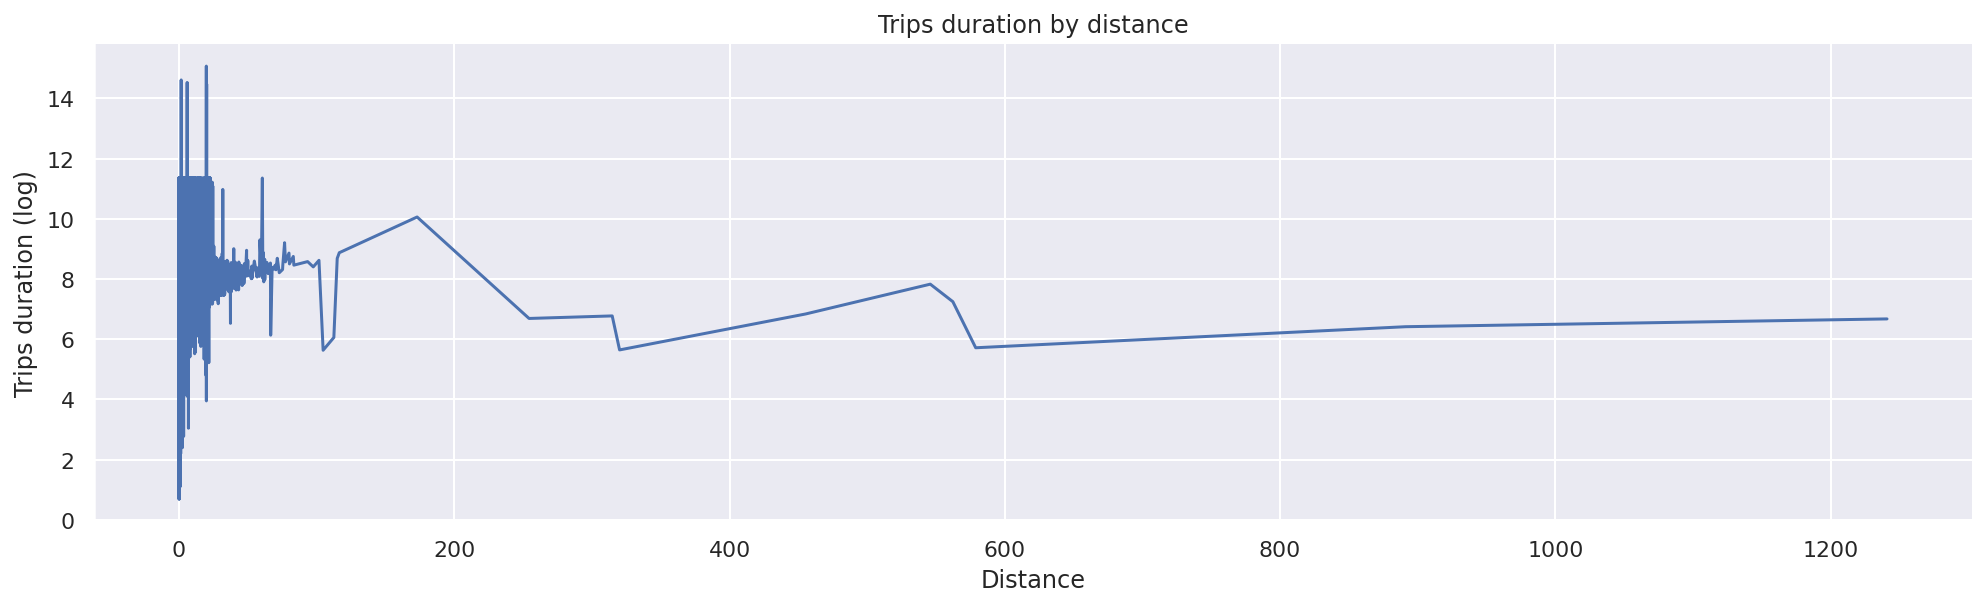

In [ ]:
ax = sns.relplot(y='log_trip_duration', x='distance_haversine', data=train, kind='line')
ax.set(title='Trips duration by distance', xlabel='Distance', ylabel='Trips duration (log)')
ax.figure.set_size_inches(16, 4)
plt.show()

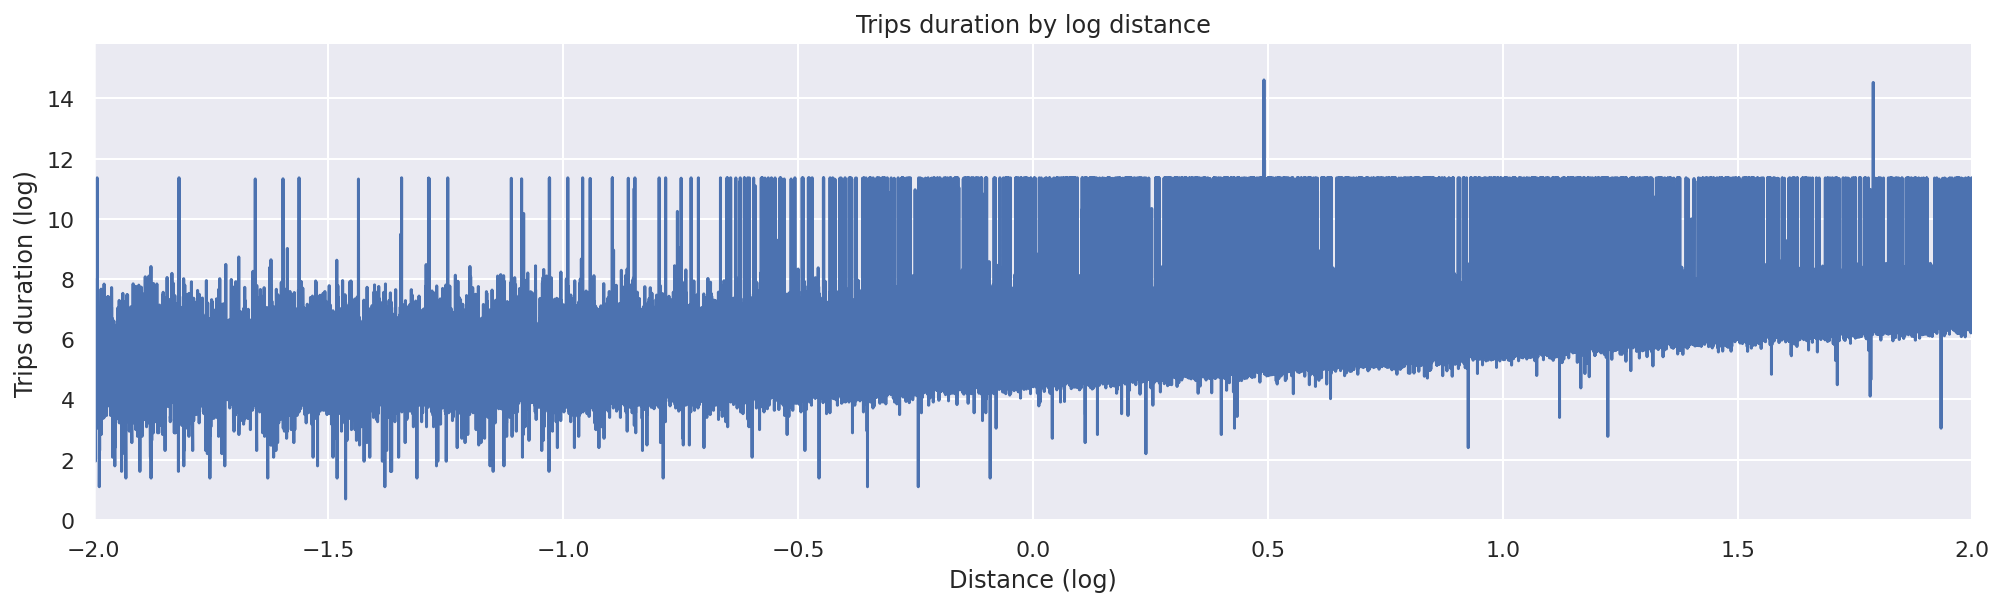

In [ ]:
ax = sns.relplot(y='log_trip_duration', x='log_dist', data=train, kind='line')
ax.set(title='Trips duration by log distance', xlabel='Distance (log)', ylabel='Trips duration (log)')
plt.xlim(-2, 2)
ax.figure.set_size_inches(16, 4)
plt.show()

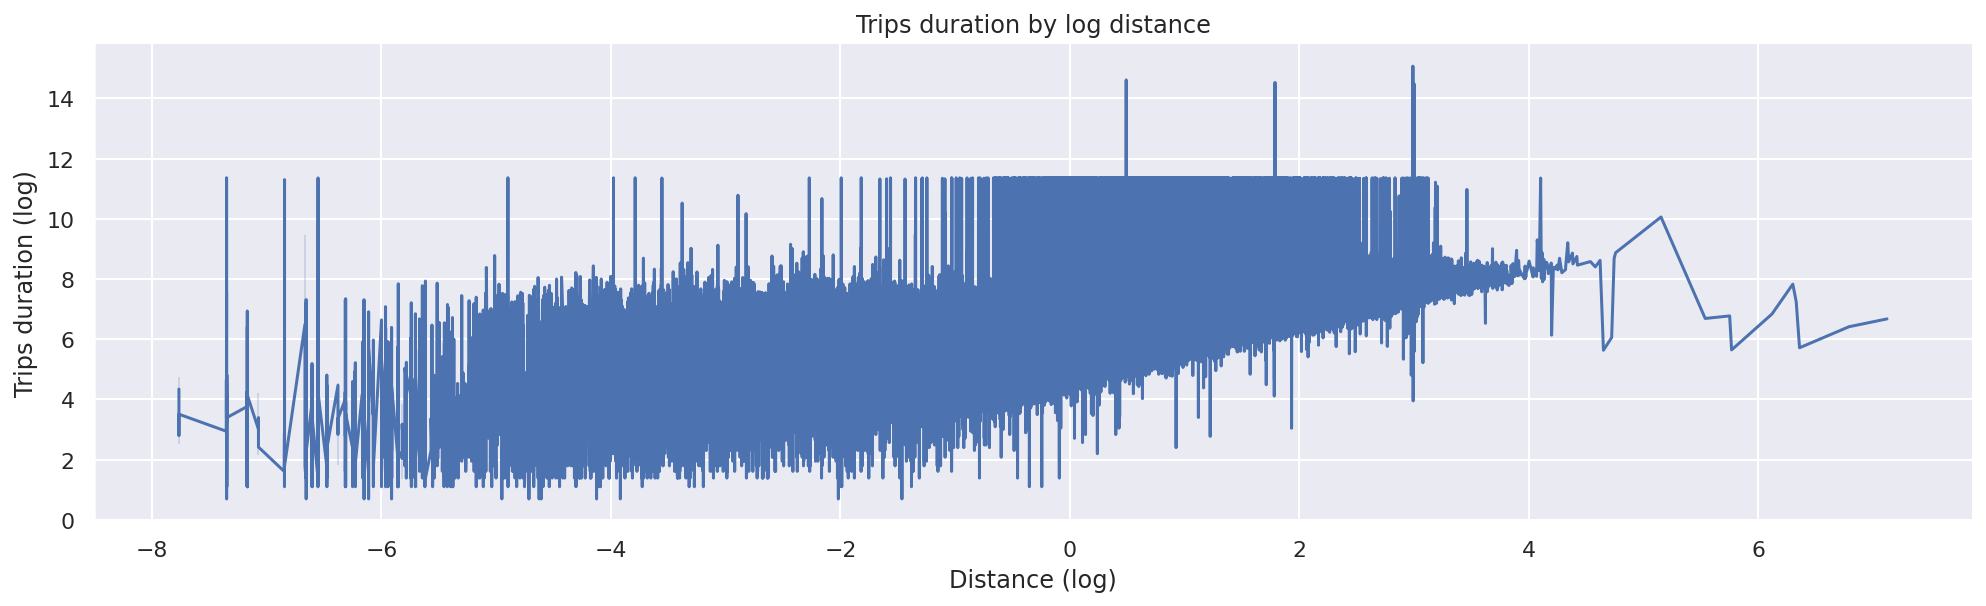

In [ ]:
ax = sns.relplot(y='log_trip_duration', x='log_dist', data=train, kind='line')
ax.set(title='Trips duration by log distance', xlabel='Distance (log)', ylabel='Trips duration (log)')
ax.figure.set_size_inches(16, 4)
plt.show()

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [531]:
train['trip_duration'] = np.exp(train['log_trip_duration'])
train['speed'] = train['distance_haversine'] / train['trip_duration']

In [532]:
from matplotlib.pyplot import gcf

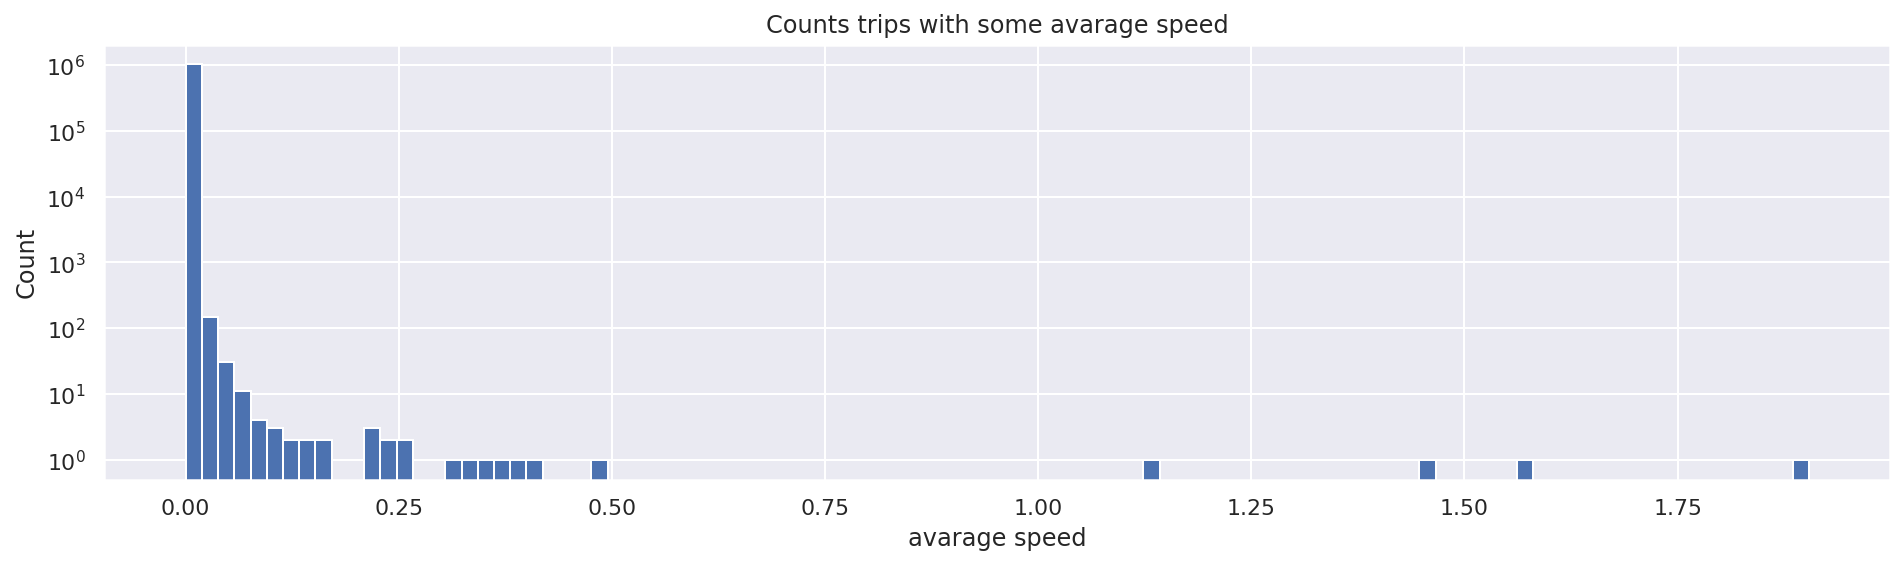

In [322]:
bins=100
plt.hist(train.speed, bins=bins)
fig = gcf()
fig.set_size_inches(16, 4)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('avarage speed')
plt.title('Counts trips with some avarage speed')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

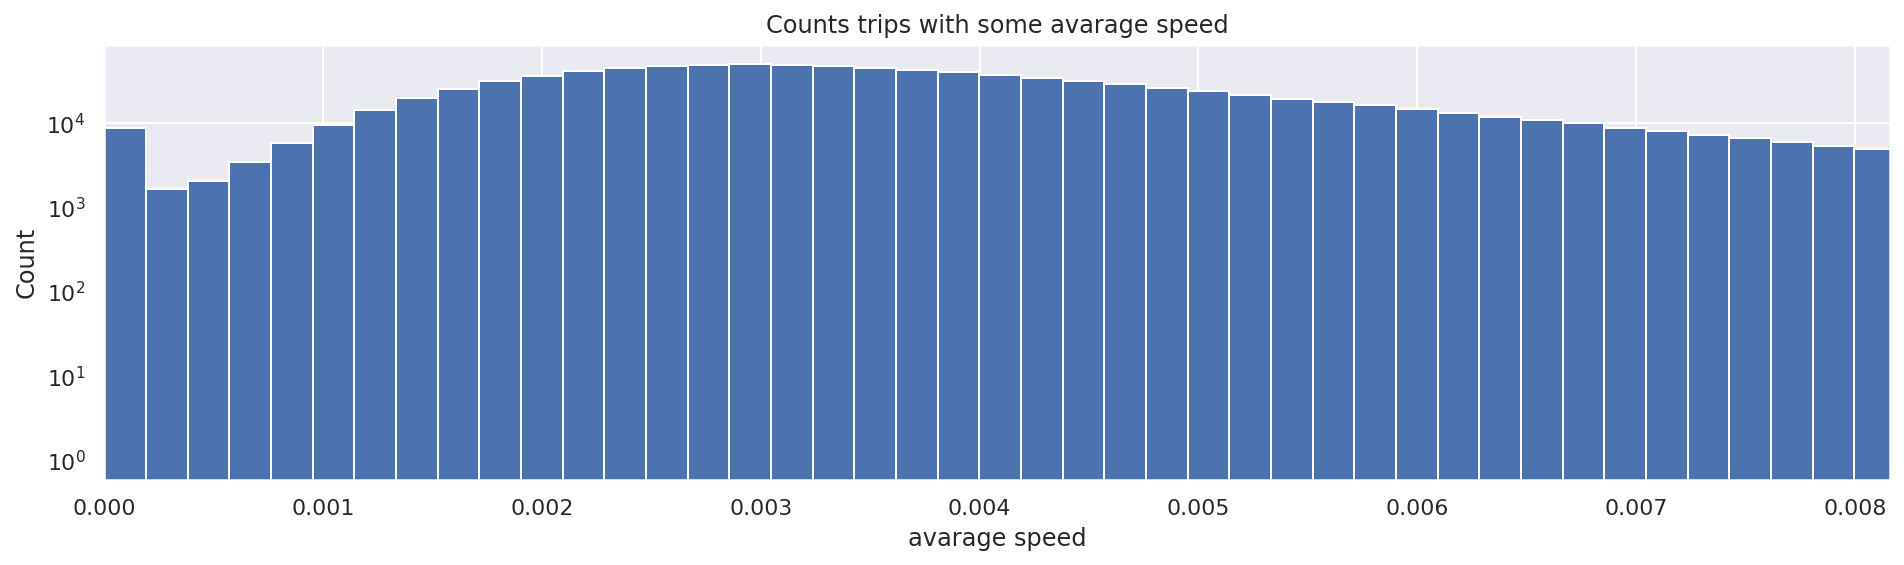

In [ ]:
bins=10000
plt.hist(train.speed, bins=bins)
fig = gcf()
fig.set_size_inches(16, 4)
plt.yscale('log')
plt.ylabel('Count')
plt.xlim(0, train.speed.quantile(0.95))
plt.xlabel('avarage speed')
plt.title('Counts trips with some avarage speed')
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

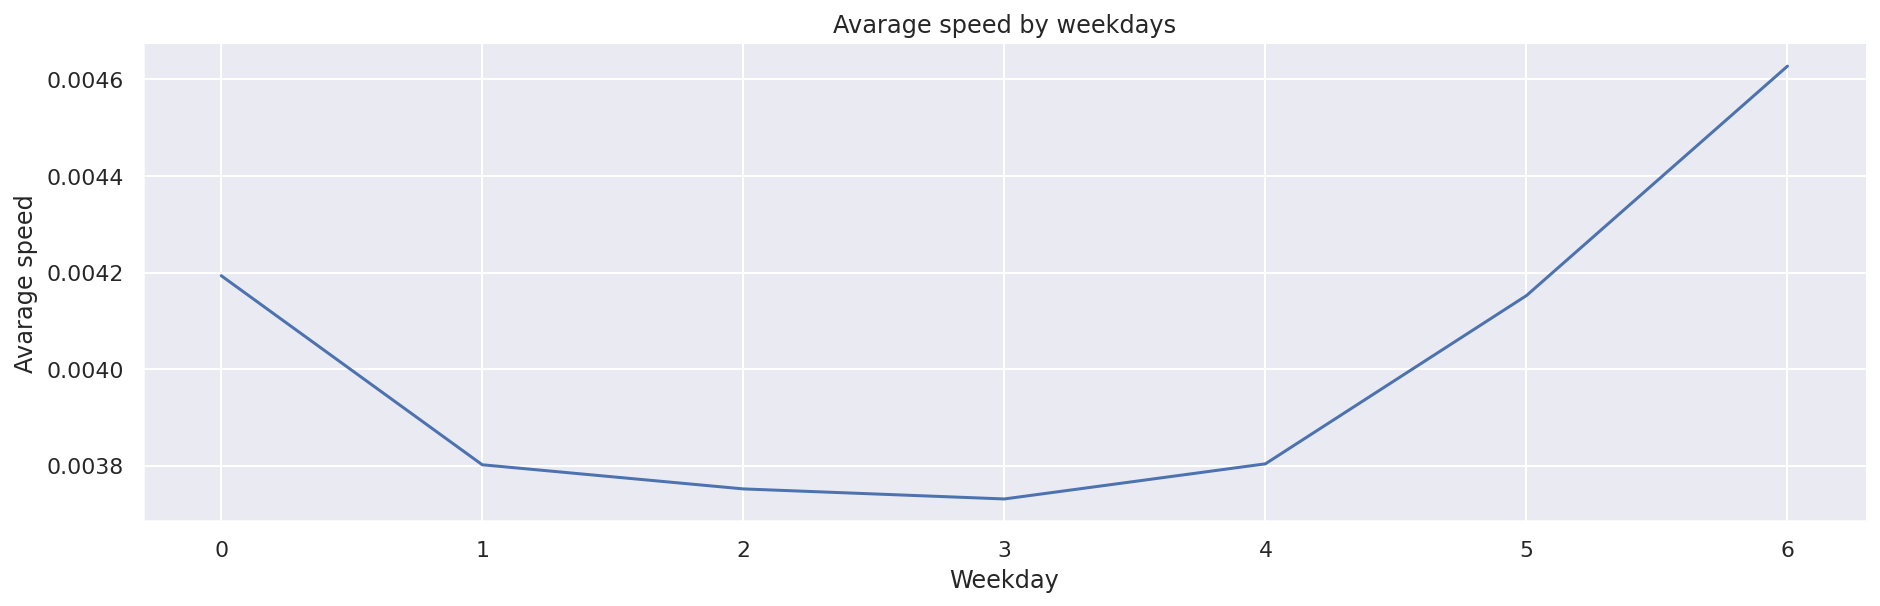

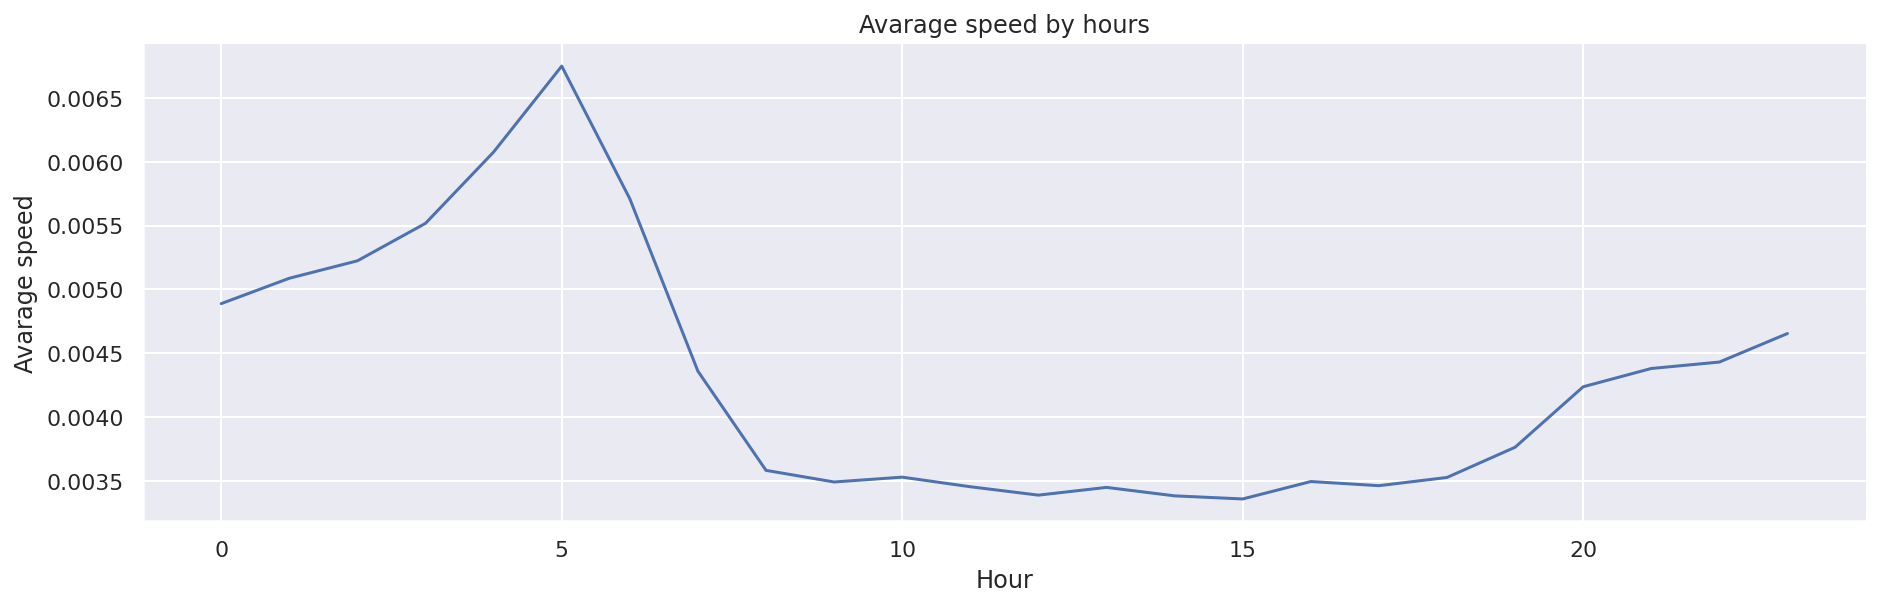

In [323]:
# By weekdays
ax = sns.relplot(x='weekday', y='speed',
                 data = train[['weekday', 'speed']].groupby('weekday', as_index=False).mean(), kind='line')
ax.figure.set_size_inches(16, 4)
ax.set(title='Avarage speed by weekdays', xlabel='Weekday', ylabel='Avarage speed')
plt.show()

# By hours
ax = sns.relplot(x='hour', y='speed',
                 data = train[['hour', 'speed']].groupby('hour', as_index=False).mean(), kind='line')
ax.figure.set_size_inches(16, 4)
ax.set(title='Avarage speed by hours', xlabel='Hour', ylabel='Avarage speed')
plt.show()

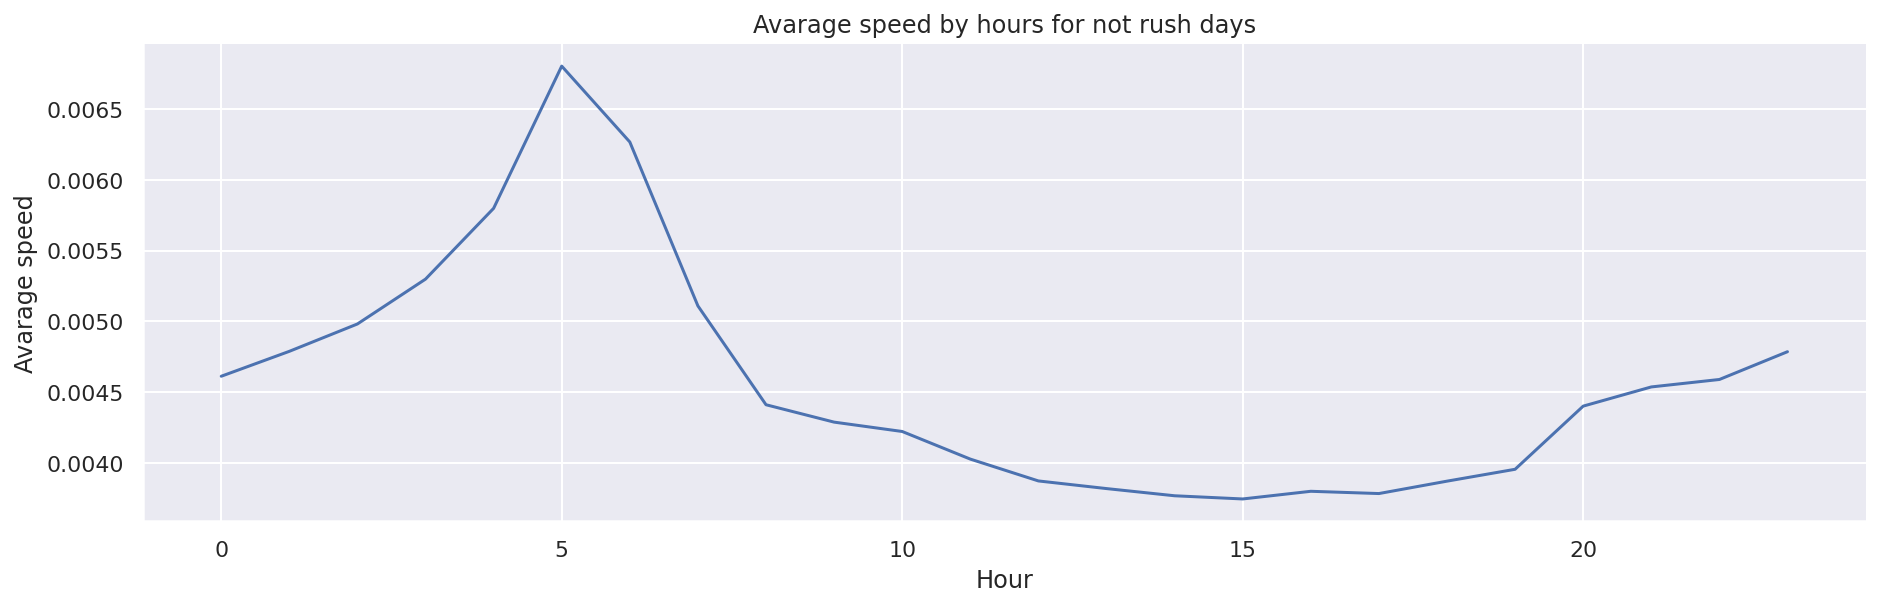

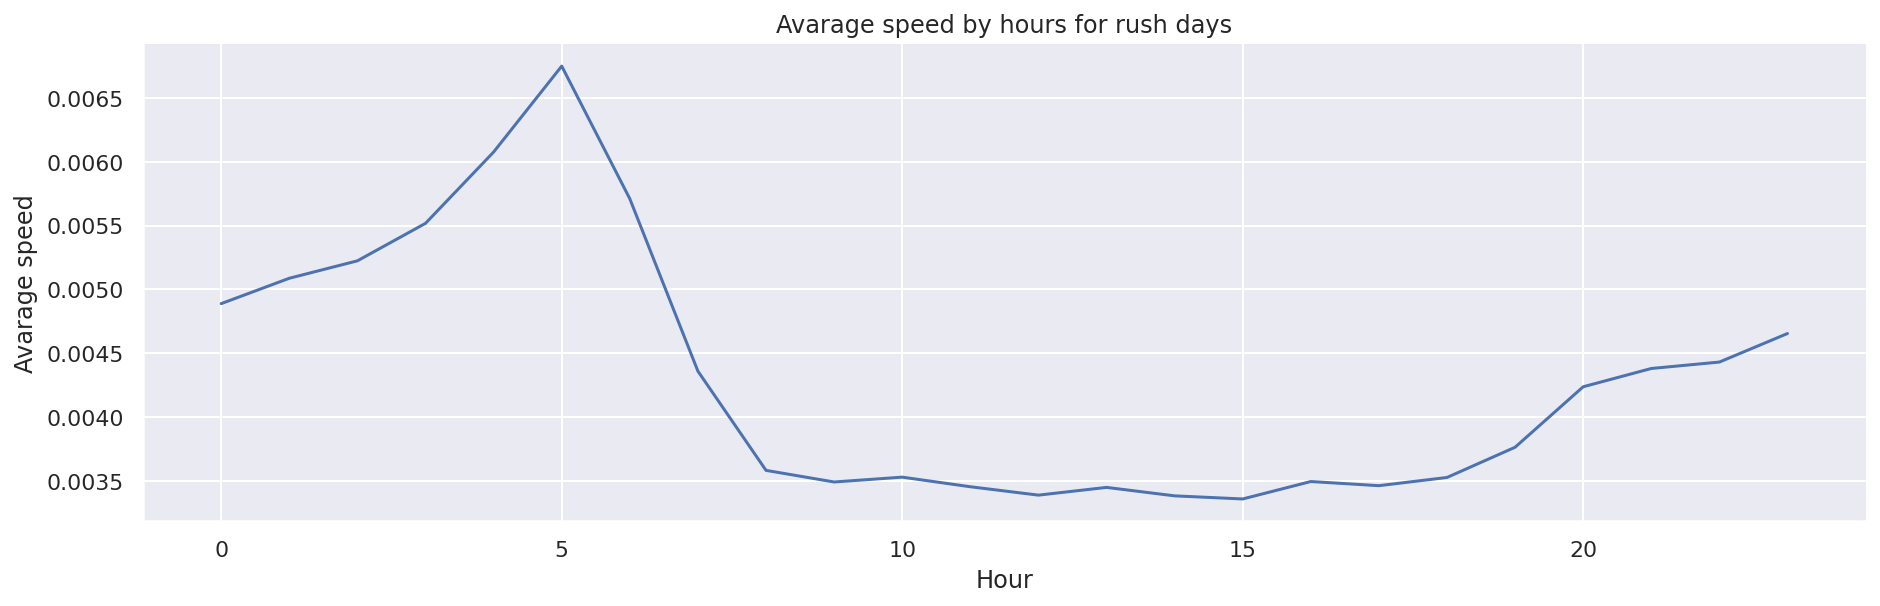

In [324]:
# By hours
ax = sns.relplot(x='hour', y='speed', data =
                 train[(train['weekday'] > 4) | (train['weekday'] < 1)][['hour', 'speed']]
                 .groupby('hour', as_index=False).mean(), kind='line')
ax.figure.set_size_inches(16, 4)
ax.set(title='Avarage speed by hours for not rush days', xlabel='Hour', ylabel='Avarage speed')
plt.show()

ax = sns.relplot(x='hour', y='speed', data =
                 train[(train['weekday'] < 5) | (train['weekday'] > 0)][['hour', 'speed']]
                 .groupby('hour', as_index=False).mean(), kind='line')
ax.figure.set_size_inches(16, 4)
ax.set(title='Avarage speed by hours for rush days', xlabel='Hour', ylabel='Avarage speed')
plt.show()

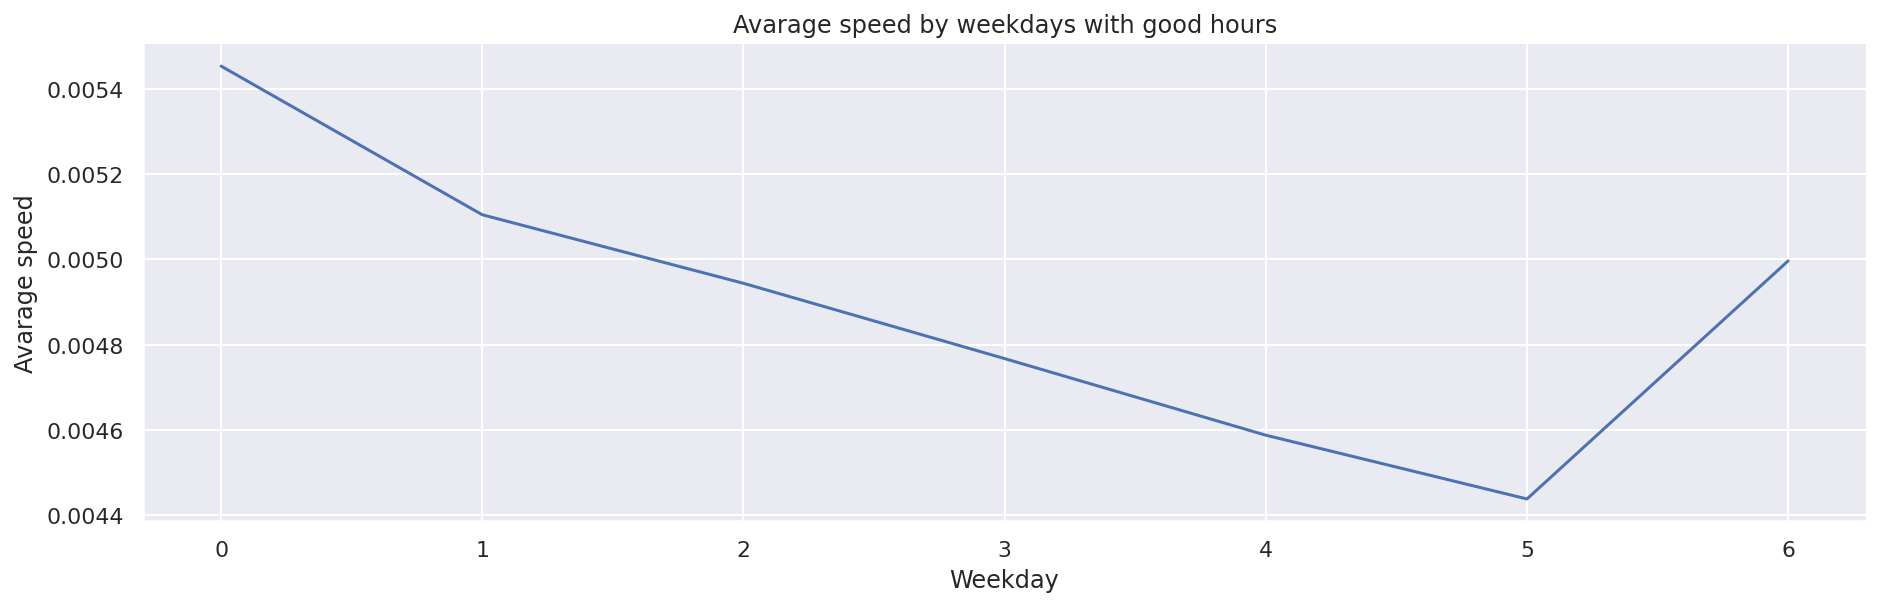

In [ ]:
# By weekdays
ax = sns.relplot(x='weekday', y='speed', data =
                 train[(train['hour'] > 20) | (train['hour'] < 6)][['weekday', 'speed']]
                 .groupby('weekday', as_index=False).mean(), kind='line')
ax.figure.set_size_inches(16, 4)
ax.set(title='Avarage speed by weekdays with good hours', xlabel='Weekday', ylabel='Avarage speed')
plt.show()

In [533]:
train.drop(['speed'], axis=1, inplace=True)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения? Потому что через него и расстояние можно вычислить время напрямую

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна? Днем (в часы пик) видимо из-за пробок; максимальна? В 5 утра. Заметим также, что день недели влияет в основном на 7-10 часов

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [534]:
# Rush
train['is_rush'] = 0
test['is_rush'] = 0
train.loc[(train['hour'] < 19) & (((train['hour'] > 6) & (train['weekday'] < 5) & (train['weekday'] > 0))
                              | (train['hour'] > 9)), 'is_rush'] = 1
test.loc[(test['hour'] < 19) & (((test['hour'] > 6) & (test['weekday'] < 5) & (test['weekday'] > 0))
                            | (train['hour'] > 9)), 'is_rush'] = 1

# Free
train['is_free'] = 0
test['is_free'] = 0
train.loc[(train['hour'] < 6) & (train['hour'] > 0), 'is_free'] = 1
test.loc[(test['hour'] < 6) & (test['hour'] > 0), 'is_free'] = 1

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [535]:
train['is_start_airport_John'] = 0
test['is_start_airport_John'] = 0

train['is_ended_airport_John'] = 0
test['is_ended_airport_John'] = 0

train['is_start_airport_Liberty'] = 0
test['is_start_airport_Liberty'] = 0

train['is_ended_airport_Liberty'] = 0
test['is_ended_airport_Liberty'] = 0

In [536]:
def set_true(df, col1, col2, inplace_col, cordinates):
    df.loc[(df[col1] < cordinates[0]) & (df[col1] > cordinates[1]) &
          (df[col2] > cordinates[2]) & (df[col2] < cordinates[3]), inplace_col] = 1


set_true(train, 'pickup_latitude', 'pickup_longitude', 'is_start_airport_John', [40.67, 40.62, -73.81, -73.76])
set_true(train, 'dropoff_latitude', 'dropoff_longitude', 'is_ended_airport_John', [40.67, 40.62, -73.81, -73.76])

set_true(test, 'pickup_latitude', 'pickup_longitude', 'is_start_airport_John', [40.67, 40.62, -73.81, -73.76])
set_true(test, 'dropoff_latitude', 'dropoff_longitude', 'is_ended_airport_John', [40.67, 40.62, -73.81, -73.76])

set_true(train, 'pickup_latitude', 'pickup_longitude', 'is_start_airport_Liberty', [40.72, 40.66, -74.2, -74.15])
set_true(train, 'dropoff_latitude', 'dropoff_longitude', 'is_ended_airport_Liberty', [40.72, 40.66, -74.2, -74.15])

set_true(test, 'pickup_latitude', 'pickup_longitude', 'is_start_airport_Liberty', [40.72, 40.66, -74.2, -74.15])
set_true(test, 'dropoff_latitude', 'dropoff_longitude', 'is_ended_airport_Liberty', [40.72, 40.66, -74.2, -74.15])

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

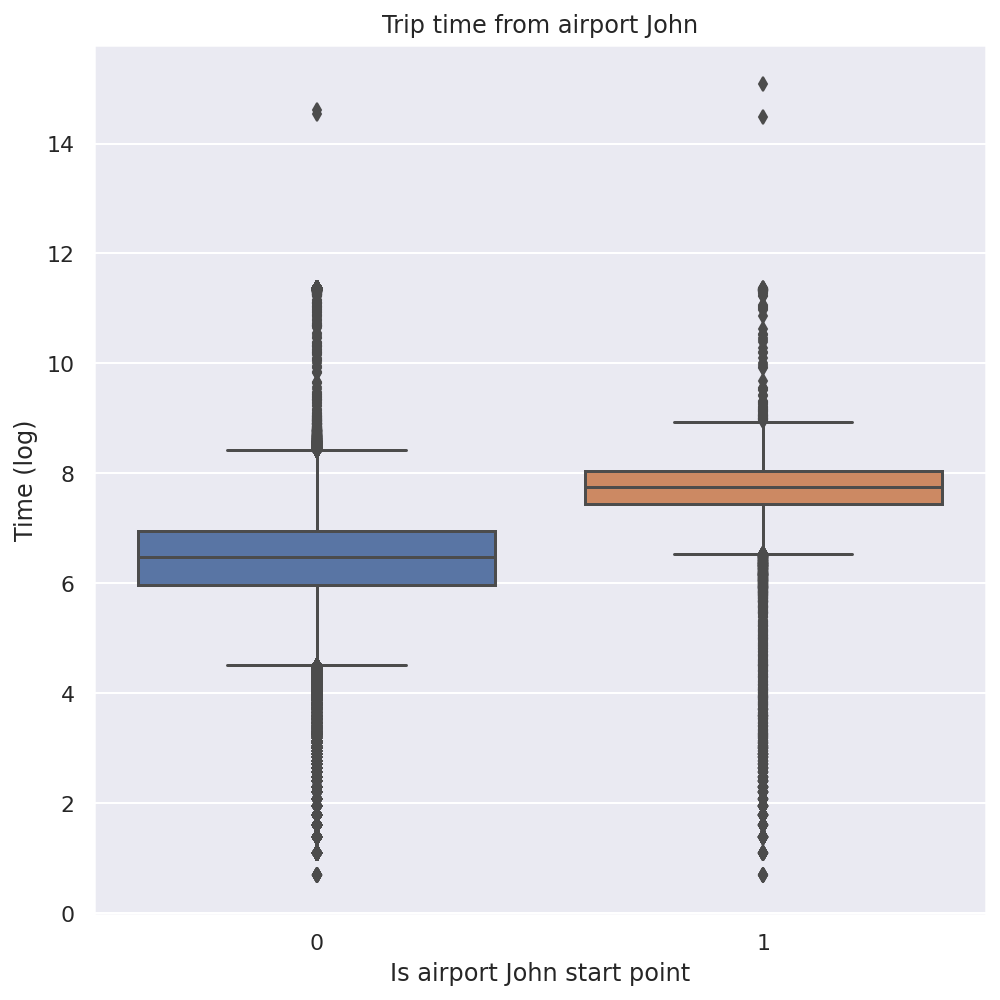

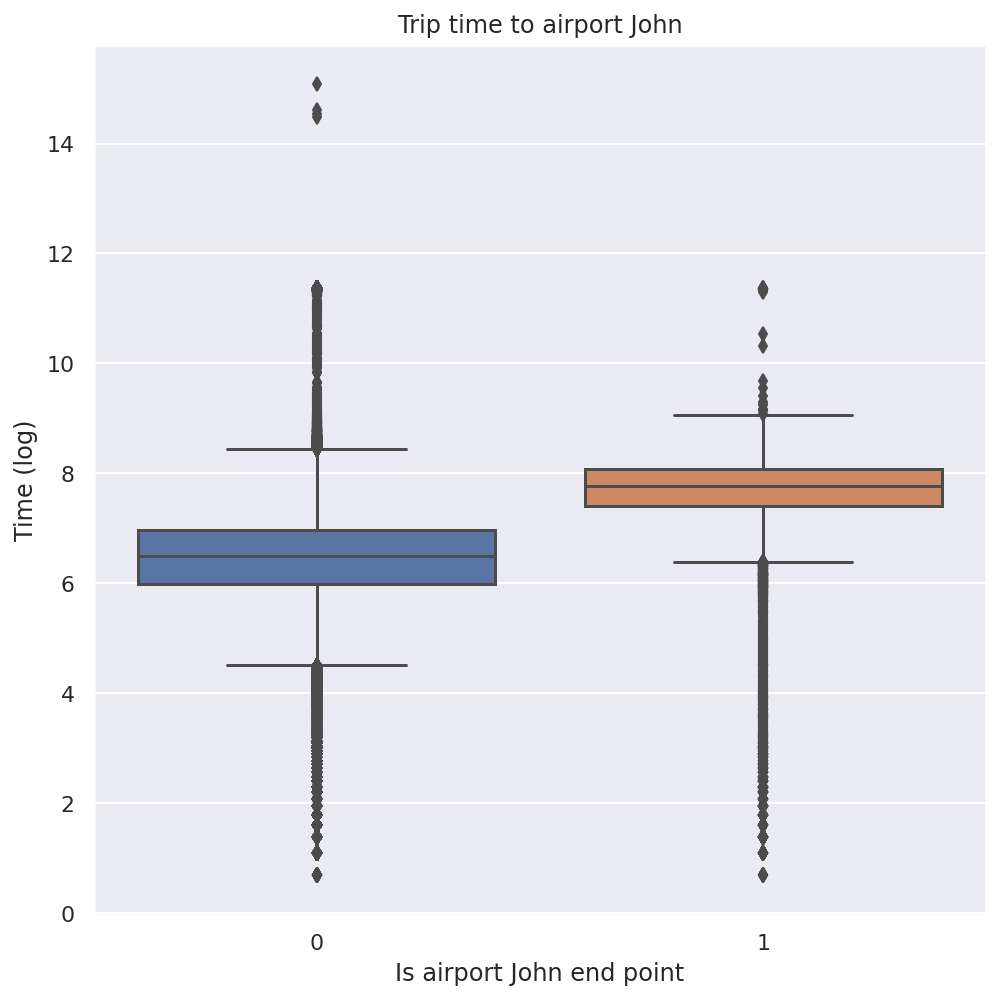

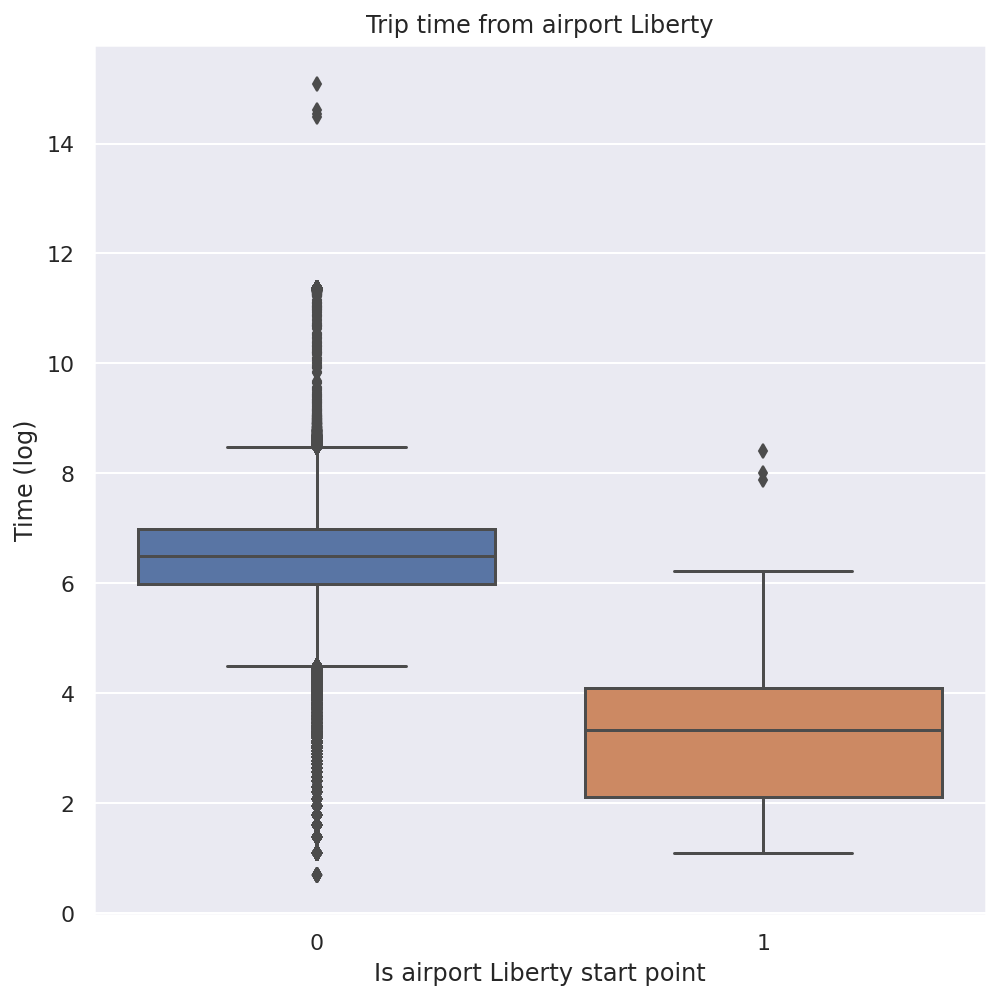

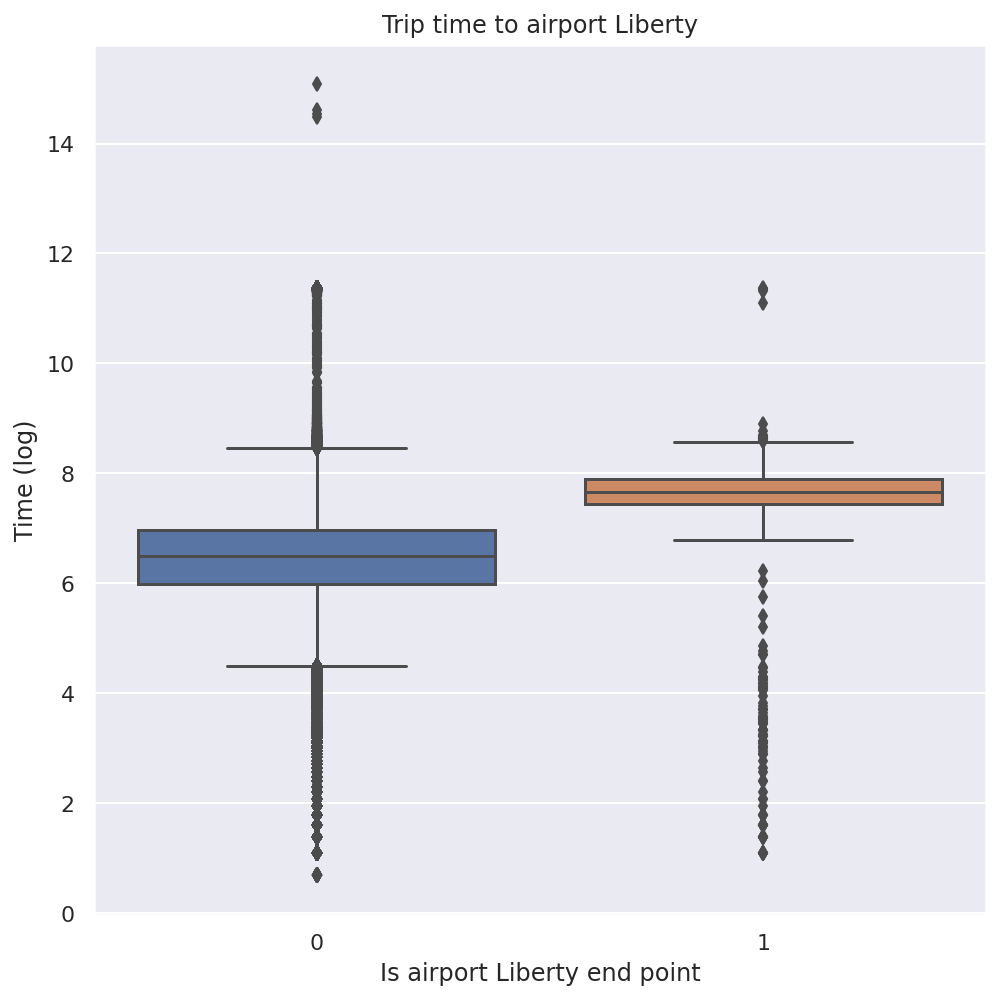

In [537]:
ax = sns.boxplot(x="is_start_airport_John", y="log_trip_duration", data=train)
ax.figure.set_size_inches(8, 8)
ax.set(title='Trip time from airport John', xlabel='Is airport John start point', ylabel='Time (log)')
plt.show()

ax = sns.boxplot(x="is_ended_airport_John", y="log_trip_duration", data=train)
ax.figure.set_size_inches(8, 8)
ax.set(title='Trip time to airport John', xlabel='Is airport John end point', ylabel='Time (log)')
plt.show()

ax = sns.boxplot(x="is_start_airport_Liberty", y="log_trip_duration", data=train)
ax.figure.set_size_inches(8, 8)
ax.set(title='Trip time from airport Liberty', xlabel='Is airport Liberty start point', ylabel='Time (log)')
plt.show()

ax = sns.boxplot(x="is_ended_airport_Liberty", y="log_trip_duration", data=train)
ax.figure.set_size_inches(8, 8)
ax.set(title='Trip time to airport Liberty', xlabel='Is airport Liberty end point', ylabel='Time (log)')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки? Да, особенно если вспомнить, что это всё на лог шкале

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [538]:
from sklearn.base import BaseEstimator, TransformerMixin

In [539]:
train.head()

id  vendor_id  ... is_start_airport_Liberty  is_ended_airport_Liberty
0  id2875421          2  ...                        0                         0
1  id2377394          1  ...                        0                         0
2  id3858529          2  ...                        0                         0
3  id3504673          2  ...                        0                         0
4  id2181028          2  ...                        0                         0

[5 rows x 25 columns]

In [540]:
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def fill_coordinates(self, X, data):
        res = X[data['coordinates']].copy()
        res['pickup_location'] = -1
        res['dropoff_location'] = -1
        for i, loc in enumerate(data['locations']):
          res.iloc[i:i+1] = i

        for i, loc in enumerate(data['locations']):
            res.loc[
                (((loc[0] < res['pickup_latitude']) & (loc[1] >= res['pickup_latitude'])) &
               ((loc[2] < res['pickup_longitude']) & (loc[3] >= res['pickup_longitude']))), 'pickup_location'
            ] = i
            res.loc[
                (((loc[0] < res['dropoff_latitude']) & (loc[1] >= res['dropoff_latitude'])) &
               ((loc[2] < res['dropoff_longitude']) & (loc[3] >= res['dropoff_longitude']))), 'dropoff_location'
            ] = i
        return res[['pickup_location', 'dropoff_location']]
    
    
    def fit_transform(self, X, data, ohe):
        X_ret = np.append(ohe.fit_transform(X[data['cotegorial']]),
                          StandardScaler().fit(X[data['numeric']]).transform(X[data['numeric']]), axis=1)
        return np.append(ohe.fit_transform(self.fill_coordinates(X, data)), X_ret, axis=1)

In [541]:
def fill_coordinates(x_start, x_end, y_start, y_end, steps):
    result = []
    dx = (x_end - x_start) / steps
    dy = (y_end - y_start) / steps
    for i in range(steps):
        for j in range(steps):
            result.append([x_start + i * dx, x_start + (i + 1) * dx, 
                           y_start + j * dy, y_start + (j + 1) * dy])
    return result

In [542]:
data = {
    'numeric': ['month', 'day_of_year', 'log_dist', 'is_anomaly_v1', 'is_anomaly_v2', 'is_rush', 'is_free',
                'is_start_airport_John', 'is_ended_airport_John', 'is_start_airport_Liberty', 'is_ended_airport_Liberty'],
    'cotegorial': ['weekday', 'hour'],
    'coordinates': ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
    'locations': fill_coordinates(40.68, 40.82, -74.03, -73.9, 5) # Тут в конце ток 5, потому что ломался код
}

In [543]:
train.loc[(train['log_dist'] == -np.inf), 'log_dist'] = 0
test.loc[(test['log_dist'] == -np.inf), 'log_dist'] = 0

In [544]:
mgt = MapGridTransformer()
X_train = mgt.fit_transform(train, data, ohe)
y_train = train['log_trip_duration']
X_test = mgt.fit_transform(test, data, ohe)
y_test = test['log_trip_duration']

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [545]:
model = Ridge()
BuildPredict(model, X_train, y_train, X_test, y_test)

Test RMSE = 0.4780
Train RMSE = 0.4783


0.47801607905377025

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [546]:
print(train[['passenger_count']].value_counts(),
      train[['vendor_id']].value_counts(),
      train[['store_and_fwd_flag']].value_counts())

passenger_count
1                  723569
2                  147130
5                   54835
3                   41897
6                   33765
4                   19813
0                      37
7                       3
9                       1
8                       1
dtype: int64 vendor_id
2            545730
1            475321
dtype: int64 store_and_fwd_flag
N                     1015396
Y                        5655
dtype: int64


In [547]:
print(test[['passenger_count']].value_counts(),
      test[['vendor_id']].value_counts(),
      test[['store_and_fwd_flag']].value_counts())

passenger_count
1                  309971
2                   63188
5                   23254
3                   17999
6                   14568
4                    8591
0                      23
dtype: int64 vendor_id
2            234573
1            203021
dtype: int64 store_and_fwd_flag
N                     435204
Y                       2390
dtype: int64


In [548]:
copy = test[0:3].copy()
copy.loc[copy['vendor_id'] == 1,'passenger_count'] = 7
copy.loc[copy['vendor_id'] == 2,'passenger_count'] = 8
copy.loc[copy['is_rush'] == 0,'passenger_count'] = 9

# Добавляем строки, чтобы количество возможных значений было равных
test = test.append(copy, ignore_index=True)

Как можно заметить passenger_count в тесте меньше, поэтому в будущем добавим столбцы

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

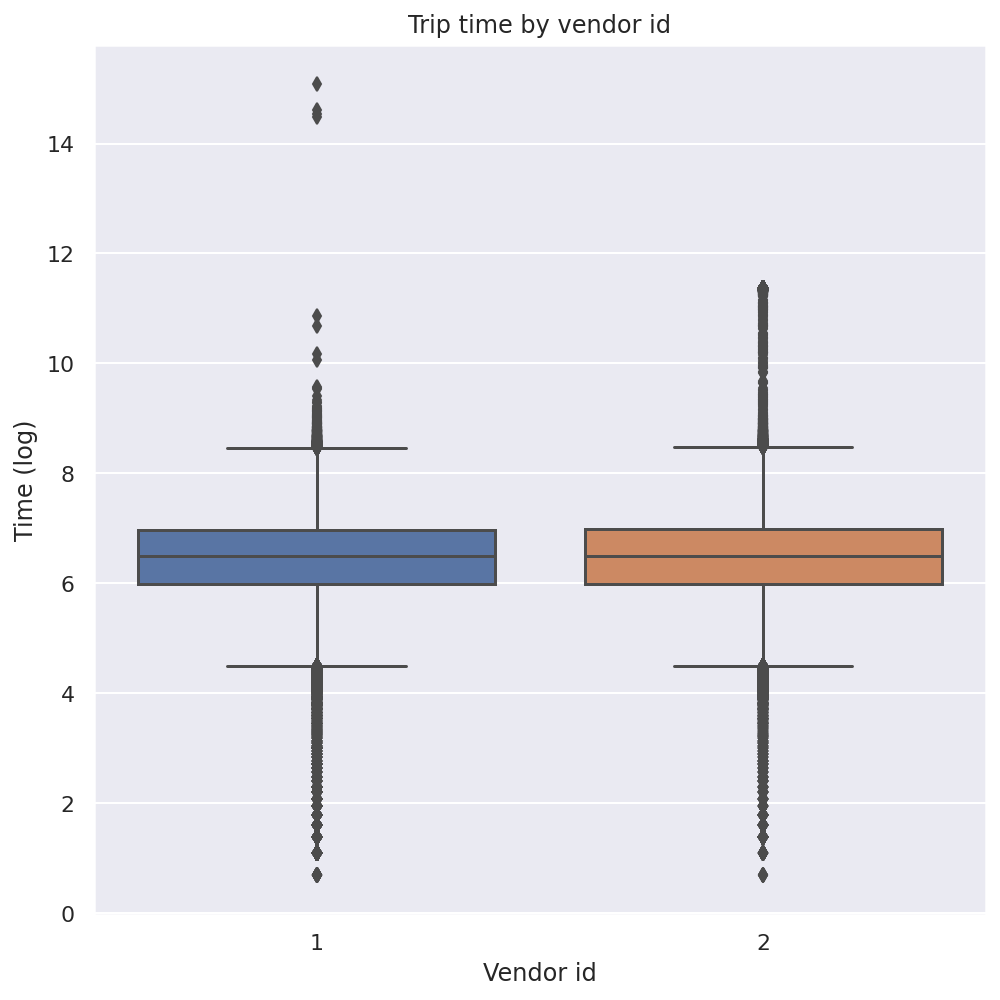

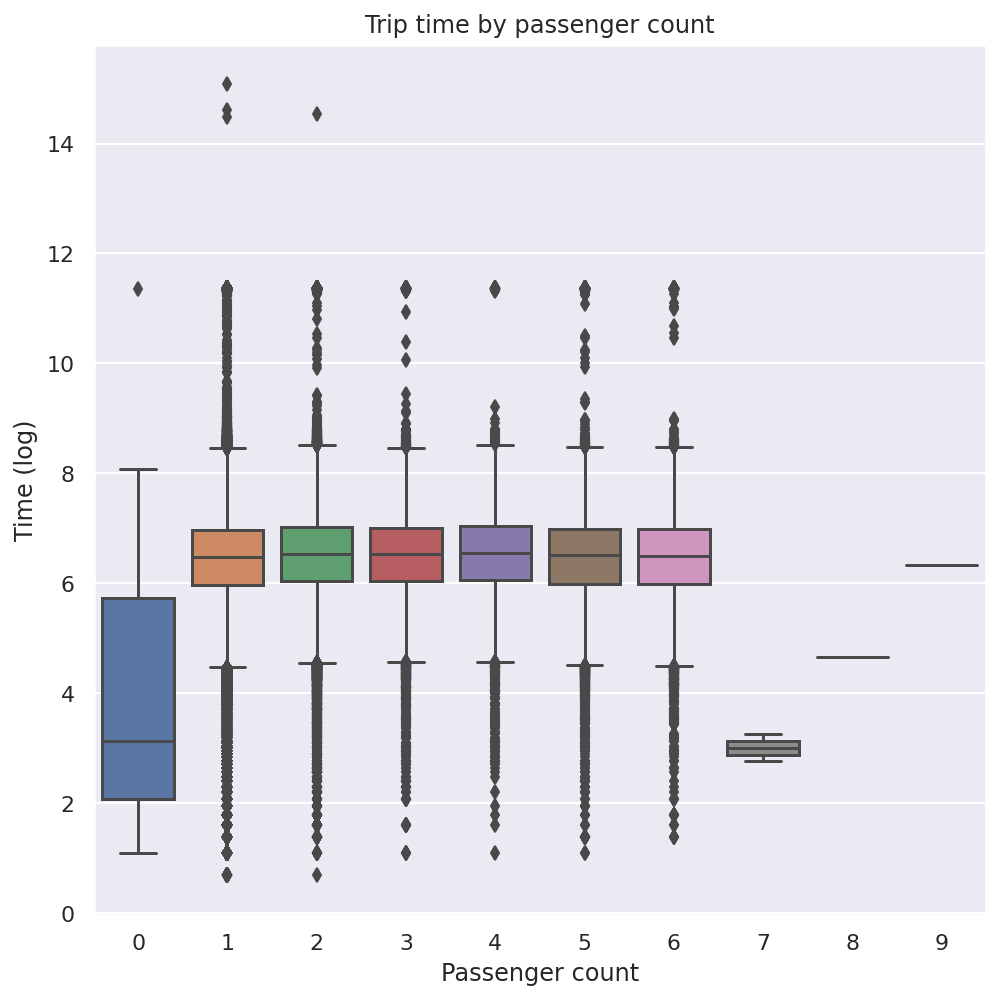

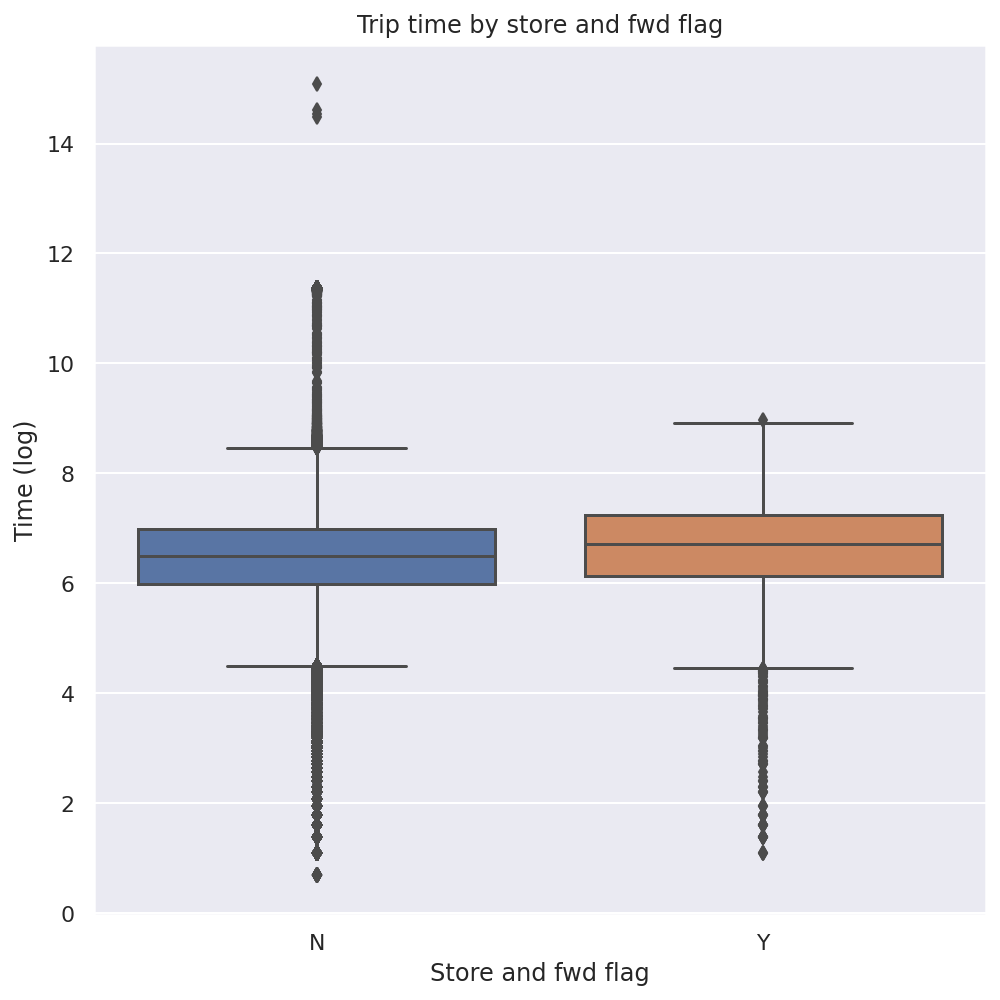

In [549]:
ax = sns.boxplot(x="vendor_id", y="log_trip_duration", data=train)
ax.figure.set_size_inches(8, 8)
ax.set(title='Trip time by vendor id', xlabel='Vendor id', ylabel='Time (log)')
plt.show()

ax = sns.boxplot(x="passenger_count", y="log_trip_duration", data=train)
ax.figure.set_size_inches(8, 8)
ax.set(title='Trip time by passenger count', xlabel='Passenger count', ylabel='Time (log)')
plt.show()

ax = sns.boxplot(x="store_and_fwd_flag", y="log_trip_duration", data=train)
ax.figure.set_size_inches(8, 8)
ax.set(title='Trip time by store and fwd flag', xlabel='Store and fwd flag', ylabel='Time (log)')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [550]:
test.head()

id  vendor_id  ... is_start_airport_Liberty  is_ended_airport_Liberty
0  id1319211          2  ...                        0                         0
1  id1618159          1  ...                        0                         0
2  id1585137          1  ...                        0                         0
3  id0766646          1  ...                        0                         0
4  id3320120          2  ...                        0                         0

[5 rows x 24 columns]

In [551]:
def put_one_if_equal(df, col, new_col, elem):
    df[new_col] = 0
    df.loc[df[col] == elem, new_col] = 1

In [552]:
put_one_if_equal(train, 'vendor_id', 'vendor_num', 2)
put_one_if_equal(train, 'store_and_fwd_flag', 'store_and_fwd', 'Y')
put_one_if_equal(test, 'vendor_id', 'vendor_num', 2)
put_one_if_equal(test, 'store_and_fwd_flag', 'store_and_fwd', 'Y')

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными? Похоже на то, что нет, однако с помощью предыдущих что-то может измениться

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [553]:
data = {
    'numeric': ['month', 'day_of_year', 'log_dist', 'is_anomaly_v1', 'is_anomaly_v2', 'is_rush', 'is_free',
                'is_start_airport_John', 'is_ended_airport_John', 'is_start_airport_Liberty', 'is_ended_airport_Liberty',
               'vendor_num', 'store_and_fwd'],
    'cotegorial': ['weekday', 'hour', 'passenger_count'],
    'coordinates': ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
    'locations': fill_coordinates(40.68, 40.82, -74.03, -73.9, 5)
}

In [554]:
X_train = mgt.fit_transform(train, data, ohe)
y_train = train['log_trip_duration']
X_test = mgt.fit_transform(test, data, ohe)
y_test = test['log_trip_duration']

In [555]:
model = Ridge()
BuildPredict(model, X_train, y_train, X_test, y_test)

Test RMSE = 0.4777
Train RMSE = 0.4780


0.47771123448512637

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных. Так и сделаем, по сути не дали.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [556]:
train.drop(['vendor_num', 'vendor_id', 'store_and_fwd', 'store_and_fwd_flag', 'passenger_count'], axis=1, inplace=True)
test.drop(['vendor_num', 'vendor_id', 'store_and_fwd', 'store_and_fwd_flag', 'passenger_count'], axis=1, inplace=True)

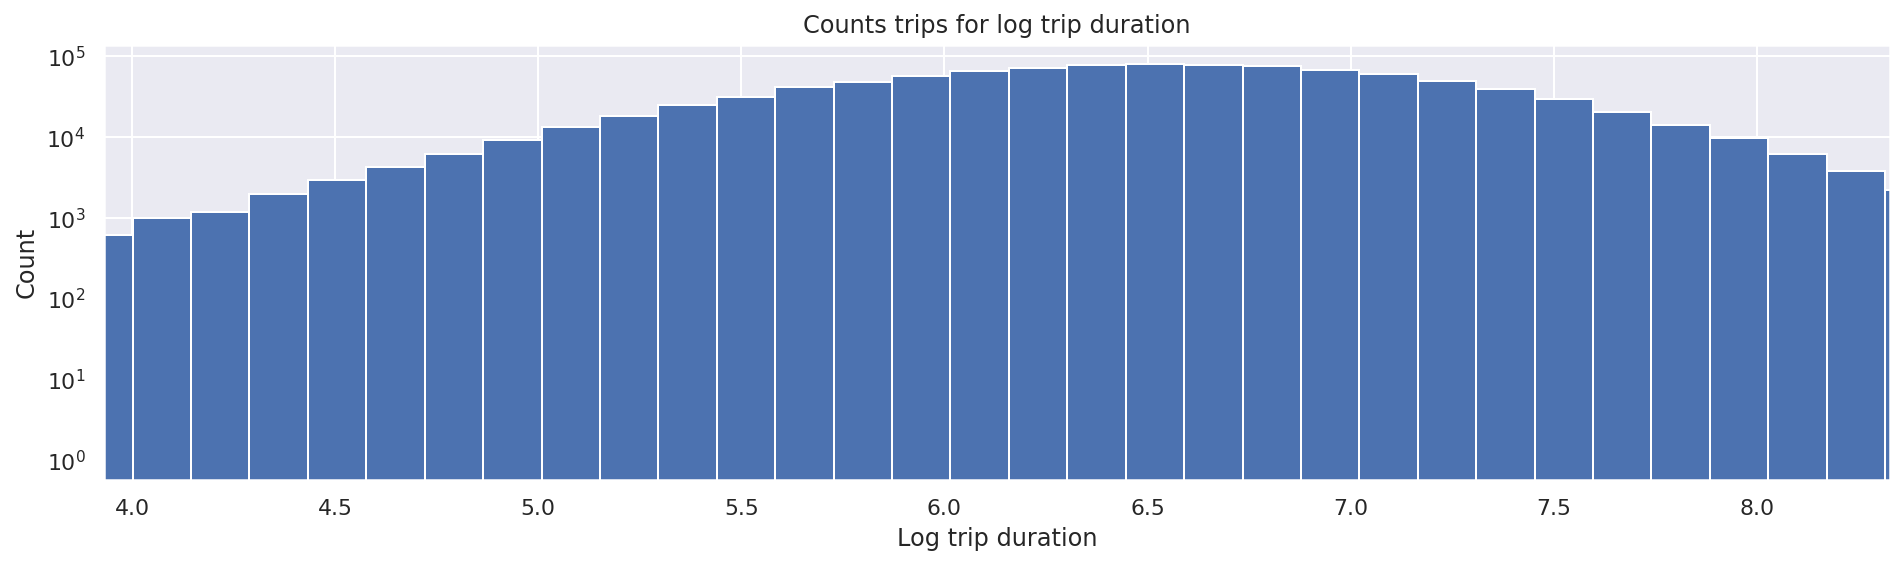

In [557]:
bins=100
plt.hist(train.log_trip_duration, bins=bins)
fig = gcf()
fig.set_size_inches(16, 4)
plt.yscale('log')
plt.ylabel('Count')
plt.xlim(train.log_trip_duration.quantile(0.005), train.log_trip_duration.quantile(0.995))
plt.xlabel('Log trip duration')
plt.title('Counts trips for log trip duration')
plt.show()

In [558]:
def drop_row_1(df, quant, col, inplace_col):
  return df.drop(df[(df[col] > df[col].quantile(quant)) |
                 (df[col] < df[col].quantile(1 - quant))].index, inplace=inplace_col)

In [559]:
drop_row_1(train, 0.995, 'log_trip_duration', True)

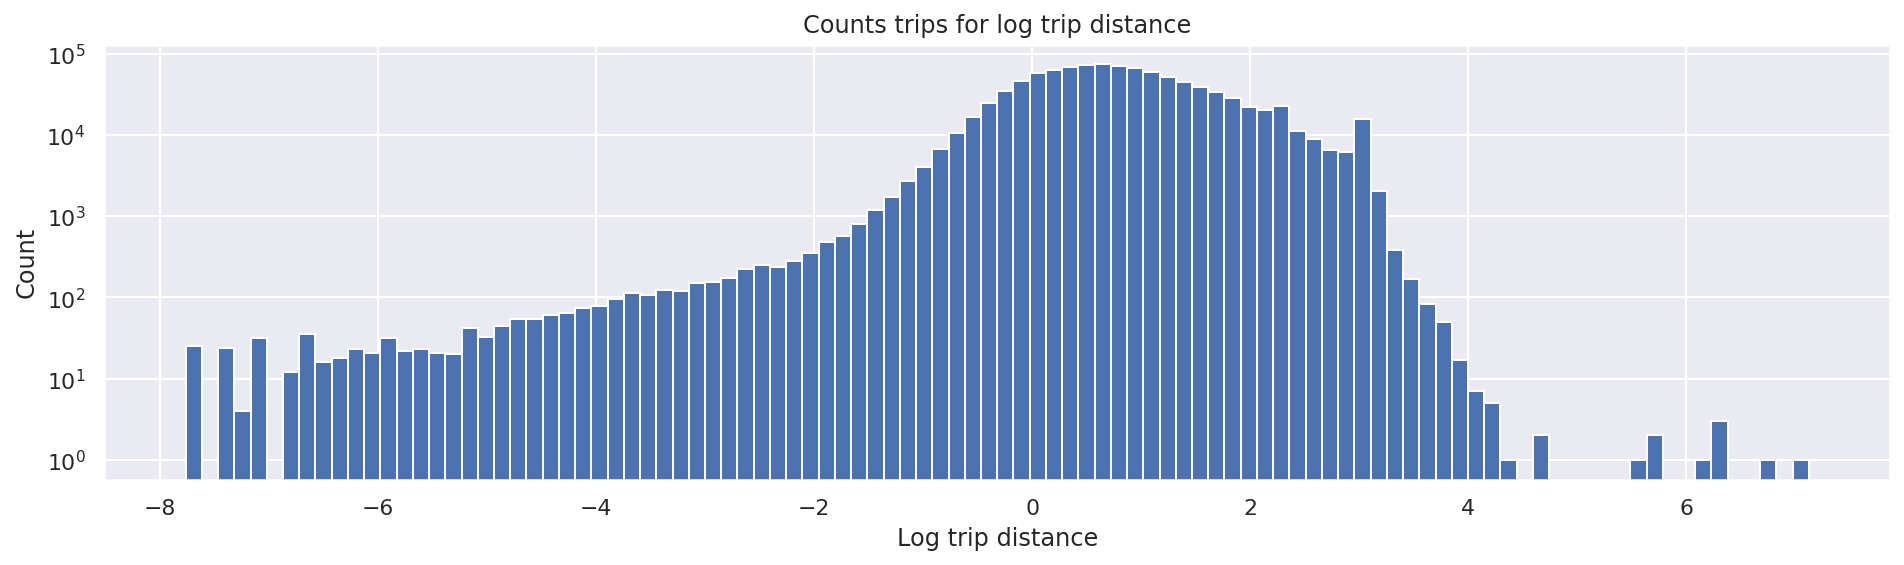

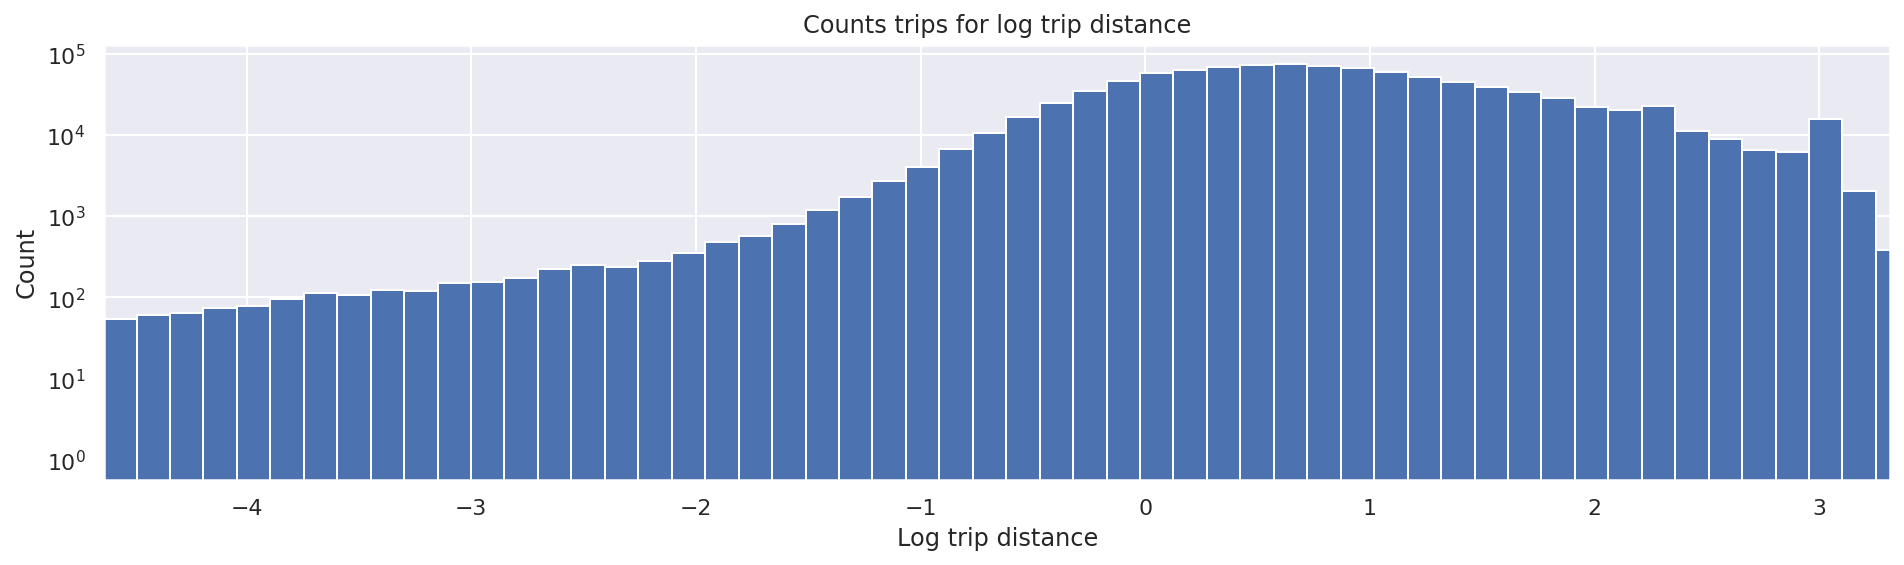

In [560]:
bins=100
plt.hist(train.log_dist, bins=bins)
fig = gcf()
fig.set_size_inches(16, 4)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Log trip distance')
plt.title('Counts trips for log trip distance')
plt.show()

bins=100
plt.hist(train.log_dist, bins=bins)
fig = gcf()
fig.set_size_inches(16, 4)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Log trip distance')
plt.xlim(train.log_dist.quantile(0.0005), train.log_dist.quantile(0.9995))
plt.title('Counts trips for log trip distance')
plt.show()

In [561]:
drop_row_1(train, 0.9995, 'log_dist', True)
train

id  ... is_ended_airport_Liberty
0        id2875421  ...                        0
1        id2377394  ...                        0
2        id3858529  ...                        0
3        id3504673  ...                        0
4        id2181028  ...                        0
...            ...  ...                      ...
1021046  id1949613  ...                        0
1021047  id0898940  ...                        0
1021048  id3360058  ...                        0
1021049  id1782606  ...                        0
1021050  id1319211  ...                        0

[1009908 rows x 22 columns]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

Я немного поработал с ними до этого, и все, где принимаются 2 значения сделал не категориальными, а просто проставил 1, 0 и сделал их числовыми. Что дало те же результаты. Однако считаю, что стоит объеденить для аэропортов.

In [562]:
train['is_John_airport'] = 0
train.loc[((train['is_start_airport_John']) & (train['is_ended_airport_John'])), 'is_John_airport'] = 1

train['is_Liberty_airport'] = 0
train.loc[((train['is_start_airport_Liberty']) & (train['is_ended_airport_Liberty'])), 'is_Liberty_airport'] = 1


test['is_John_airport'] = 0
test.loc[(test['is_start_airport_John']) & (test['is_ended_airport_John']), 'is_John_airport'] = 1

test['is_Liberty_airport'] = 0
test.loc[(test['is_start_airport_Liberty']) & (test['is_ended_airport_Liberty']), 'is_Liberty_airport'] = 1

В аномалиях разное поведение, поэтому менять не будем

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

По причине описанной выше их не настолько много. Ещё зависит от шага

In [563]:
data = {
    'numeric': ['month', 'day_of_year', 'log_dist', 'is_anomaly_v1', 'is_anomaly_v2', 'is_rush', 'is_free',
                'is_John_airport', 'is_Liberty_airport'],
    'cotegorial': ['weekday', 'hour'],
    'coordinates': ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
    'locations': fill_coordinates(40.68, 40.82, -74.03, -73.9, 5)
}

In [564]:
X_train = mgt.fit_transform(train, data, ohe)
y_train = train['log_trip_duration']

In [565]:
print(X_train.shape[1] - len(data['numeric']) - len(data['cotegorial']) - 1) # 1 for locations

80


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [566]:
X_test = mgt.fit_transform(test, data, ohe)
y_test = test['log_trip_duration']

In [567]:
from sklearn.linear_model import Lasso

In [568]:
model = Lasso()
BuildPredict(model, X_train, y_train, X_test, y_test)

Test RMSE = 0.7959
Train RMSE = 0.7219


0.7959215492914474

In [569]:
model = Ridge()
BuildPredict(model, X_train, y_train, X_test, y_test)

Test RMSE = 0.4797
Train RMSE = 0.4107


0.47972800573964053

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [570]:
delimeter = int((train.shape[0] * 8) / 10)
X_train = mgt.fit_transform(train[:delimeter], data, ohe)
y_train = train[:delimeter]['log_trip_duration']

X_test = mgt.fit_transform(train[delimeter:], data, ohe)
y_test = train[delimeter:]['log_trip_duration']

In [571]:
min_mse = 1000
best_alp = -1

for alp in [0.00005, 0.0001, 0.0002, 0.0005,
            0.001, 0.002, 0.005, 0.01, 0.2, 0.5, 1, 2]:
  model = Lasso(alpha=alp)
  print("alpha = ", alp)
  test_mse = BuildPredict(model, X_train, y_train, X_test, y_test)
  if test_mse < min_mse:
    min_mse = test_mse
    best_alp = alp

print('best alpha = ', best_alp, '\nMin rmse =', min_mse)

alpha =  5e-05
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.0001
Test RMSE = 0.4105
Train RMSE = 0.4108
alpha =  0.0002
Test RMSE = 0.4106
Train RMSE = 0.4110
alpha =  0.0005
Test RMSE = 0.4112
Train RMSE = 0.4115
alpha =  0.001
Test RMSE = 0.4121
Train RMSE = 0.4125
alpha =  0.002
Test RMSE = 0.4144
Train RMSE = 0.4148
alpha =  0.005
Test RMSE = 0.4211
Train RMSE = 0.4215
alpha =  0.01
Test RMSE = 0.4277
Train RMSE = 0.4280
alpha =  0.2
Test RMSE = 0.4940
Train RMSE = 0.4934
alpha =  0.5
Test RMSE = 0.6747
Train RMSE = 0.6734
alpha =  1
Test RMSE = 0.7230
Train RMSE = 0.7216
alpha =  2
Test RMSE = 0.7230
Train RMSE = 0.7216
best alpha =  5e-05 
Min rmse = 0.4104251670830866


In [572]:
min_mse = 1000
best_alp = -1

for alp in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 
            0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.5, 2, 3, 5, 10, 100]:
  model = Ridge(alpha=alp)
  print("alpha = ", alp)
  test_std = BuildPredict(model, X_train, y_train, X_test, y_test)
  if test_std < min_mse:
    min_mse = test_std
    best_alp = alp

print('best alpha = ', best_alp, '\nMin rmse =', min_mse)

alpha =  0.01
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.02
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.03
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.04
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.05
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.06
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.07
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.08
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.09
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.1
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.12
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.15
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.2
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.3
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.4
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.5
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.6
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.7
Test RMSE = 0.4104
Train RMSE = 0.4108
alpha =  0.8
Test RMSE = 0.4104
Train RMSE = 0.4108
a

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [573]:
alpha_zeroes = pd.DataFrame([[0, 0]])
for alp in [0.00005, 0.0001, 0.0002, 0.0005,
            0.001, 0.002, 0.005, 0.01, 0.2, 0.5, 1, 2]:
  model = Lasso(alpha=alp)
  model.fit(X_train, y_train)
  coefs = model.coef_
  alpha_zeroes = alpha_zeroes.append(pd.DataFrame([[alp, len(coefs[abs(coefs) < 0.0001])]]))

In [574]:
alpha_zeroes.rename(columns={0: 'alpha', 1: 'zeroes'}, inplace=True)

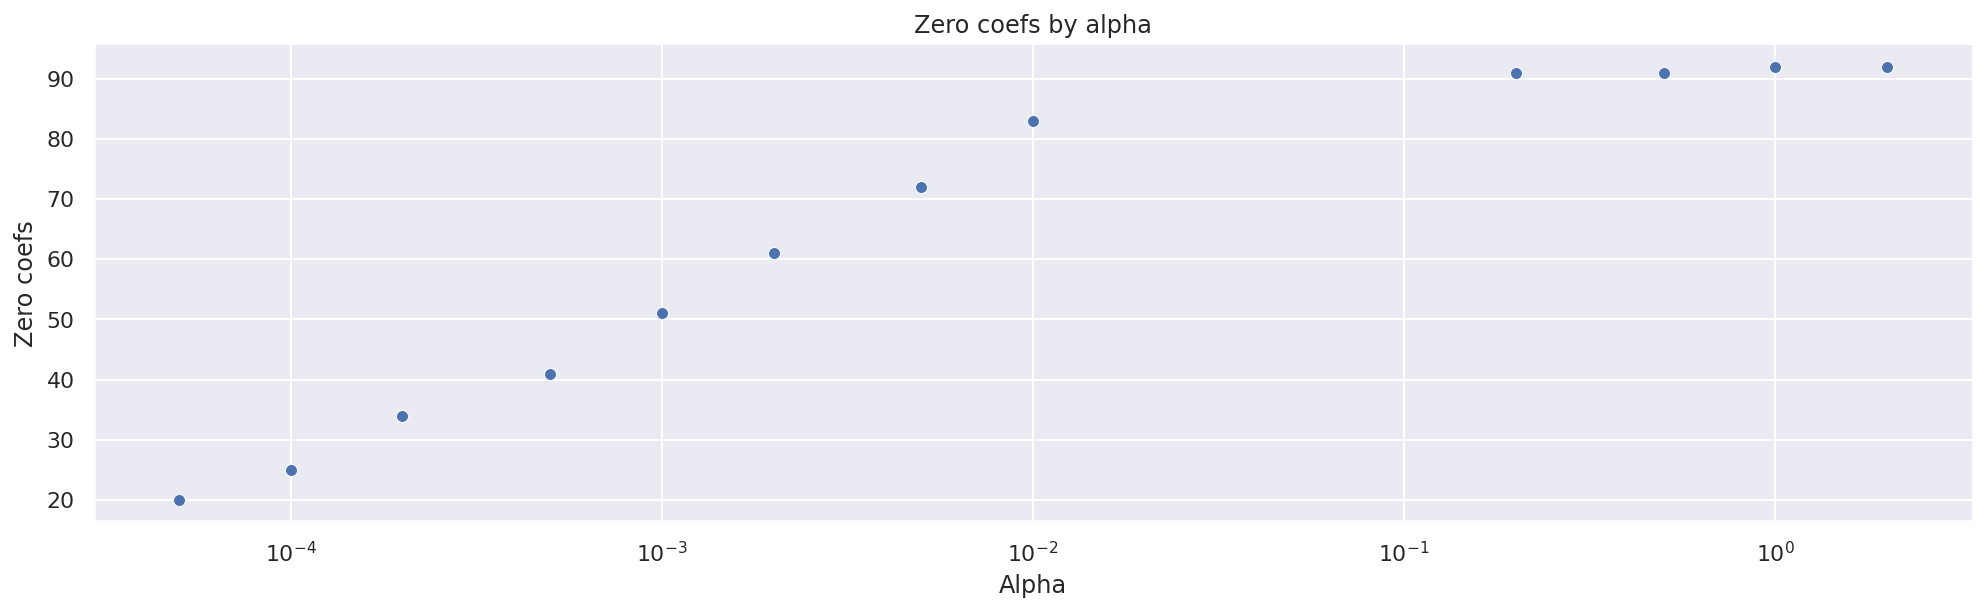

In [575]:
ax = sns.relplot(y='zeroes', x='alpha', data=alpha_zeroes[1:])
plt.xscale('log')
ax.set(title='Zero coefs by alpha', xlabel='Alpha', ylabel='Zero coefs')
ax.figure.set_size_inches(16, 4)
plt.show()

In [576]:
print(alpha_zeroes[alpha_zeroes['zeroes'] > (X_train.shape[1] / 2)])

   alpha  zeroes
0  0.001      51
0  0.002      61
0  0.005      72
0  0.010      83
0  0.200      91
0  0.500      91
0  1.000      92
0  2.000      92


Как мы знаем альфа при 0.002, Test RMSE = 0.4156. А это примерно такая точность 0.9921 (относительно лучшего случая). Потеря будет небольшой

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Переобучение

Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"? Потому что информация не линейна

In [577]:
def fill_locations(X, data):
  res = X[data['coordinates']].copy()
  res['pickup_location'] = -1
  res['dropoff_location'] = -1
  for i, loc in enumerate(data['locations']):
    res.iloc[i:i+1] = i

  for i, loc in enumerate(data['locations']):
    res.loc[
      (((loc[0] < res['pickup_latitude']) & (loc[1] >= res['pickup_latitude'])) &
      ((loc[2] < res['pickup_longitude']) & (loc[3] >= res['pickup_longitude']))), 'pickup_location'
    ] = i
    res.loc[
      (((loc[0] < res['dropoff_latitude']) & (loc[1] >= res['dropoff_latitude'])) &
      ((loc[2] < res['dropoff_longitude']) & (loc[3] >= res['dropoff_longitude']))), 'dropoff_location'
    ] = i
  return res[['pickup_location', 'dropoff_location']]


train[['pickup_location', 'dropoff_location']] = fill_locations(train, data)
test[['pickup_location', 'dropoff_location']] = fill_locations(test, data)

In [578]:
mgt = MapGridTransformer()
X_train = mgt.fit_transform(train, data, ohe)
y_train = train['log_trip_duration']
X_test = mgt.fit_transform(test, data, ohe)
y_test = test['log_trip_duration']
model = Lasso(alpha=0.0002)
test_std = BuildPredict(model, X_train, y_train, X_test, y_test)

Test RMSE = 0.4810
Train RMSE = 0.4109


In [579]:
mgt = MapGridTransformer()
X_train = mgt.fit_transform(train, data, ohe)
y_train = train['log_trip_duration']
X_test = mgt.fit_transform(test, data, ohe)
y_test = test['log_trip_duration']
model = Ridge()
test_std = BuildPredict(model, X_train, y_train, X_test, y_test)

Test RMSE = 0.4797
Train RMSE = 0.4107


In [580]:
train['hash_pair_location'] = -1
train.loc[(train['pickup_location'] > -1) & (train['dropoff_location'] > -1),
          'hash_pair_location'
         ] = (train['pickup_location'] * len(data['locations'])) + train['dropoff_location']

test['hash_pair_location'] = -1
test.loc[(test['pickup_location'] > -1) & (test['dropoff_location'] > -1),
         'hash_pair_location'
        ] = (test['pickup_location'] * len(data['locations'])) + test['dropoff_location']

In [581]:
good_locations = train.groupby('hash_pair_location', axis=0, as_index=False).count()[['hash_pair_location', 'id']]
good_locations.sort_values('id', ascending=False, inplace=True)

train['pair_location'] = -1
for el in good_locations[0:101]['hash_pair_location']:
  train.loc[(train['hash_pair_location'] == el), 'pair_location'] = el

In [582]:
good_locations = test.groupby('hash_pair_location', axis=0, as_index=False).count()[['hash_pair_location', 'id']]
good_locations.sort_values('id', ascending=False, inplace=True)

test['pair_location'] = -1
for el in good_locations[0:101]['hash_pair_location']:
  test.loc[(test['hash_pair_location'] == el), 'pair_location'] = el

In [583]:
def make_X_train(X, data, ohe):
  return np.append(ohe.fit_transform(X[data['cotegorial']]),
                   StandardScaler().fit(X[data['numeric']]).transform(X[data['numeric']]), axis=1)

In [584]:
data = {
    'numeric': ['month', 'day_of_year', 'log_dist', 'is_anomaly_v1', 'is_anomaly_v2', 'is_rush', 'is_free',
                'is_John_airport', 'is_Liberty_airport'],
    'cotegorial': ['weekday', 'hour', 'pair_location'],
}

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке. Прикол они почти одинаковы

In [585]:
X_train = make_X_train(train, data, ohe)
y_train = train['log_trip_duration']
X_test = make_X_train(test, data, ohe)
y_test = test['log_trip_duration']
model = Ridge()
test_std = BuildPredict(model, X_train, y_train, X_test, y_test)

Test RMSE = 0.4922
Train RMSE = 0.4040


In [586]:
X_train = make_X_train(train, data, ohe)
y_train = train['log_trip_duration']
X_test = make_X_train(test, data, ohe)
y_test = test['log_trip_duration']
model = Lasso(alpha=0.0002)
test_std = BuildPredict(model, X_train, y_train, X_test, y_test)

Test RMSE = 0.4893
Train RMSE = 0.4052


Не успель дальше, сори(

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [587]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [588]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [589]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.